In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, Markdown

import sys
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


import time
import pickle


import noise_models as noise
import model_fitting as fit
import fig_plot as fplot
import thermo_models as thermo



sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

# Instructions

This notebook runs the fitting routines for the thermodynamic push and push-pull models. To make this run, you will need to setup the input files as follows:

1. Make datasets.csv file.
This file lists the different datasets, models, and fit parameters. The columns of this file should be:
dataset: The name of each file containing a different construct.

    model: The type of model you wish to use to fit each model. This determines which fit parameters will be necessary to fit each data set. The options are: 
    
        substrate_only: This model assumes that only the substrate exists and will only fit the background pplation rate.
    
        non-pplatable: This moel assumes the substrate cannot be pplated, and so has no fit parameters. However, we can still predict the distribution of observed pplated substrate based on the empty cell noise controls, so it is still useful to include these datasets.
    
        push: Model assumes the existence of substrate and kinase and will fit the background pplation rate, kinase zipper binding affinity, and kinase pplation rate.
    
        pushpull: Model fits the full pushpull construct with background pplation rate, kinase zipper binding affinity, kinase pplation rate, pptase zipper binding affinity, and pptase depplation rate.

    kinase_variant: Name of the kinase variant pplation rate parameter.

    kinase_zipper: Name of the kinase zipper binding affinity parameter.

    pptase_variant: Name of the pptase variant  depplation rate parameter. 

    pptase_zipper: Name of the pptase zipper binding affinity parameter. 

    substrate_col: Name of the column containing the substrate in the data file.

    phospho_col: Name of the column containing the pplated substrate in the data file.

    writer_col: Name of the column containing the kinase in the data file.

    eraser_col:  Name of the column containing the pptase in the data file.

    Note: All parameters are shared across and within datasets/models if they have the same name. This is true even if they correspond to different thermodynamic parameters (e.g., if the pptase and kinase zipper have the same name, then they are the same parameter). To ensure unique parameters, make sure they have unique names. The background pplation rate is also shared by all models by default.

2. Make noise_key.csv file
This file specifies the noise control datasets. The columns should be:

    component: The molecule species (e.g., writer, eraser, substrate, phospho).

    anti_label: The label of the column containig the antibody values for the active cells.

    GFP_label: The label of the column containig the GFP values for the active cells.

    empty_anti_label: The label of the column containig the antibody values for the empty cells.

    empty_GFP_label: The label of the column containig the GFP values for the empty cells.

3. Rename noise dataset files as follows:

    noise_writer.csv

    noise_eraser.csv

    noise_substrate_phospho_combined.csv

    noise_empty_cell.csv

# Load data

In [2]:
seed = 42

print("Seed:", seed)

rand.seed(seed)


# name of dataset folder
# label = "21_10_15_highgating"
label = "21_10_15_medhighgating"
# label = "22_01_20"
# label = "22_01_20_noGFPexpressionshift"

antibody_shift = True

components = ["phospho", "substrate", "kinase", 'pptase']


df_dataset_key = pd.read_csv("../data/"+label+"/dataset_key.csv", sep=', ', engine='python').set_index("exp_name")
display(df_dataset_key)

df_anti2GFP_key = pd.read_csv("../data/"+label+"/anti_to_GFP_key.csv", sep=', ', engine='python').set_index("component")
display(df_anti2GFP_key)


df_anti_noGFP2GFP_key = pd.read_csv("../data/"+label+"/anti_noGFP_to_GFP_key.csv", sep=', ', engine='python').set_index("component")
display(df_anti_noGFP2GFP_key)

# load datasets

df_list = []
for exp_name, row in df_dataset_key.iterrows():
    
    df = pd.read_csv("../data/{}/{}.csv".format(label, row['file_name']))     
    df = df.drop("Unnamed: 0", axis=1, errors='ignore').sample(frac=1.0, replace=True, random_state=seed).reset_index(drop=True)
#     display(df)
    
    if row['model'] == 'push' or row['model'] == "substrate_only" or row['model'] == "non-pplatable":
        df = df[[row['substrate_col'],row['phospho_col'],row['kinase_col']]].rename(columns={row['substrate_col']:'substrate_anti_exp', 
                                                                                     row['phospho_col']:'phospho_anti_exp', 
                                                                                     row['kinase_col']:'kinase_anti_exp'})
        df['pptase_anti_exp'] = 1e-8
    elif row['model'] == 'pushpull':
        df = df[[row['substrate_col'],row['phospho_col'],row['kinase_col'],row['pptase_col']]].rename(columns={row['substrate_col']:'substrate_anti_exp', 
                                                                                                       row['phospho_col']:'phospho_anti_exp', 
                                                                                                       row['kinase_col']:'kinase_anti_exp',
                                                                                                       row['pptase_col']:'pptase_anti_exp'})

    
    df['exp_name'] = exp_name
    df.index.rename('cell_index', inplace=True)
    df_list.append(df)
    
# dataframe containing all datasets   
df_data = pd.concat(df_list) #.drop("Unnamed: 0", axis=1, errors='ignore')
df_data = df_data.reset_index().set_index(['cell_index', 'exp_name'])
df_data = df_data.reorder_levels(df_data.index.names[::-1])

print(len(df_data.index))
df_data.dropna(inplace=True)
print(len(df_data.index))
df_data = df_data[(df_data[df_data.columns] > 0.0).all(axis=1)]
print(len(df_data.index))


# setup noise model dictionary
noise_models = {c:dict() for c in components}
print(noise_models)


display(df_data)

Seed: 42


file_name           model kinase_variant  \
exp_name                                                                
substrate_only                     127  substrate_only            NaN   
non-pplatable                      174   non-pplatable            174   
kinase_dead                        421            push    kinase_dead   
kinase_non-binding                RR+A            push      kinase_wt   
kinase_variant_375                 375            push            375   
kinase_variant_419                 419            push            419   
kinase_zipper_E+A                  E+A            push      kinase_wt   
kinase_zipper_E+E                  E+E            push      kinase_wt   
kinase_zipper_L+A                  L+A            push      kinase_wt   
pptase_dead                pptase dead        pushpull      kinase_wt   
pptase_non-binding  non-binding pptase        pushpull      kinase_wt   
pptase                     with pptase        pushpull      kinase_wt   

                         kinase_zipper pptase_variant       pptase_zipper  \
exp_name                                                                    
substrate_only                     NaN            NaN                 NaN   
non-pplatable                      L+A            NaN                 NaN   
kinase_dead                        L+A            NaN                 NaN   
kinase_non-binding  kinase_non-binding            NaN                 NaN   
kinase_variant_375                 L+A            NaN                 NaN   
kinase_variant_419                 L+A            NaN                 NaN   
kinase_zipper_E+A                  E+A            NaN                 NaN   
kinase_zipper_E+E                  E+E            NaN                 NaN   
kinase_zipper_L+A                  L+A            NaN                 NaN   
pptase_dead                        L+A    pptase_dead                 L+A   
pptase_non-binding                 L+A      pptase_wt  pptase_non-binding   
pptase                             L+A      pptase_wt                 L+A   

                   substrate_col phospho_col kinase_col pptase_col  
exp_name                                                            
substrate_only                ST         SpT         WT        NaN  
non-pplatable                 ST         SpT         WT        NaN  
kinase_dead                   ST         SpT         WT        NaN  
kinase_non-binding            ST         SpT         WT        NaN  
kinase_variant_375            ST         SpT         WT        NaN  
kinase_variant_419            ST         SpT         WT        NaN  
kinase_zipper_E+A             ST         SpT         WT        NaN  
kinase_zipper_E+E             ST         SpT         WT        NaN  
kinase_zipper_L+A             ST         SpT         WT        NaN  
pptase_dead                   ST         SpT         WT     pptase  
pptase_non-binding            ST         SpT         WT     pptase  
pptase                        ST         SpT         WT     pptase

file_name anti_col_name GFP_col_name
component                                                  
empty_substrate  BFP(empty cell)            ST          GFP
empty_phospho    BFP(empty cell)           SpT          GFP
empty_kinase     BFP(empty cell)            WT          GFP
empty_pptase     BFP(empty cell)        pptase          GFP
substrate            ST:SpT MOCU            ST          GFP
phospho              ST:SpT MOCU           SpT          GFP
kinase                   WT MOCU            WT          GFP
pptase               pptase MOCU        pptase          GFP

file_name anti_col_name
component                           
substrate          L+A            ST
phospho            L+A           SpT
kinase             L+A            WT
pptase     with pptase        pptase

139743
139743
139743
{'phospho': {}, 'substrate': {}, 'kinase': {}, 'pptase': {}}


substrate_anti_exp  phospho_anti_exp  \
exp_name       cell_index                                         
substrate_only 0                  2212.525146        133.354218   
               1                  4954.513184        112.124626   
               2                  3487.114746        119.673706   
               3                   253.888428        100.082169   
               4                   584.118408         39.466415   
...                                       ...               ...   
pptase         15453               605.925781        116.375717   
               15454              3005.479980          3.798526   
               15455               140.026718        260.147644   
               15456               174.096863        169.258682   
               15457               363.897980        246.208633   

                           kinase_anti_exp  pptase_anti_exp  
exp_name       cell_index                                    
substrate_only 0                 79.178284     1.000000e-08  
               1                 86.252625     1.000000e-08  
               2                 10.157516     1.000000e-08  
               3                 96.854454     1.000000e-08  
               4                118.221375     1.000000e-08  
...                                    ...              ...  
pptase         15453            585.051575     1.200013e+03  
               15454           7184.776367     4.150368e+03  
               15455            658.204529     5.767077e+02  
               15456            372.268127     7.306846e+02  
               15457            529.578430     9.265865e+02  

[139743 rows x 4 columns]

# Plot raw data for each experiment

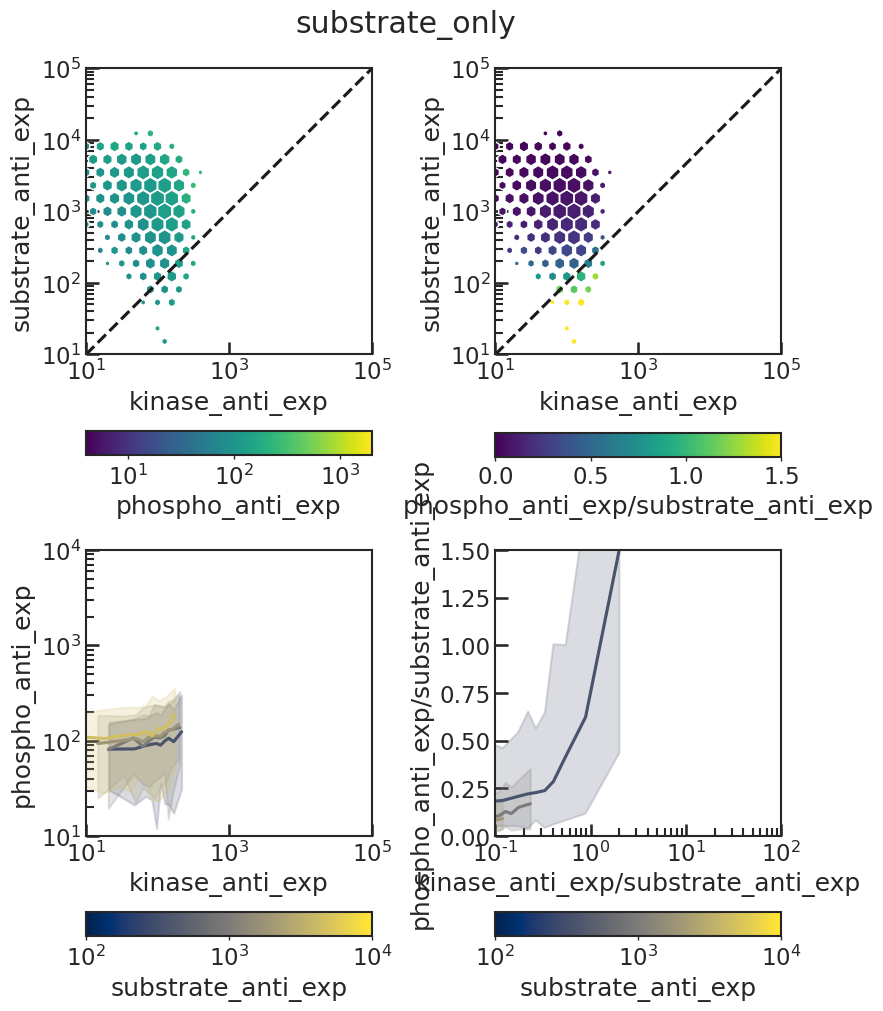

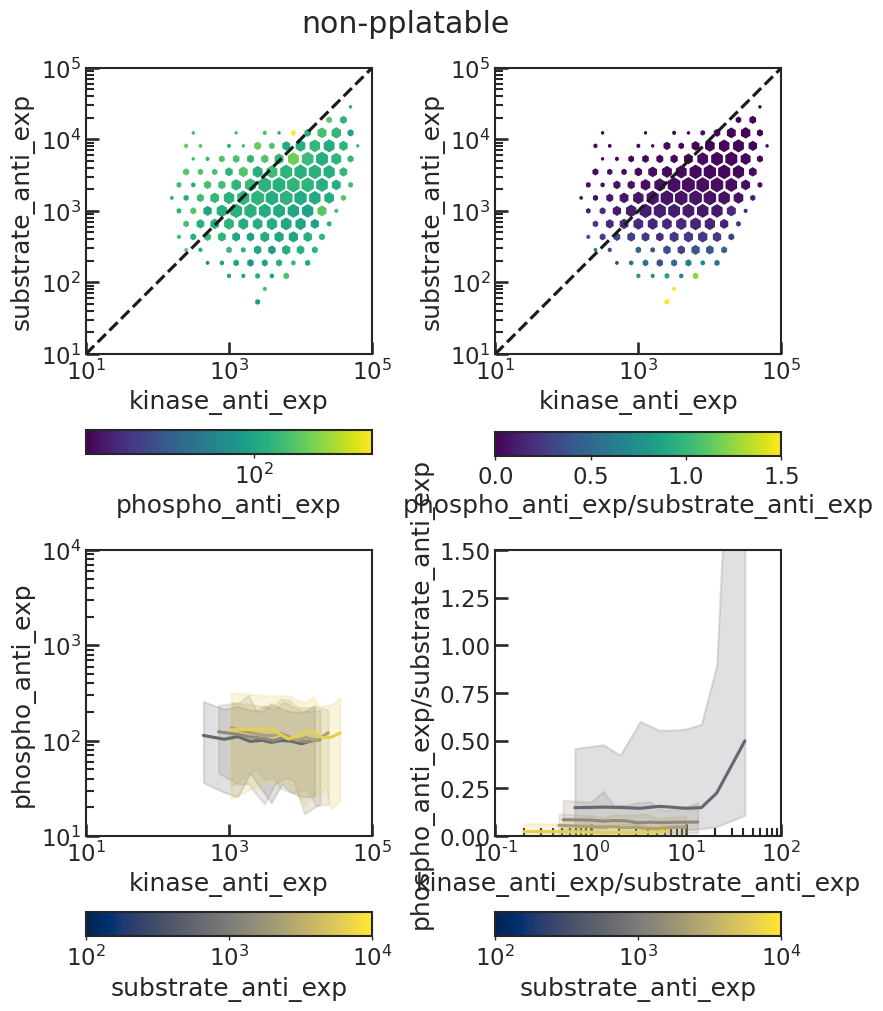

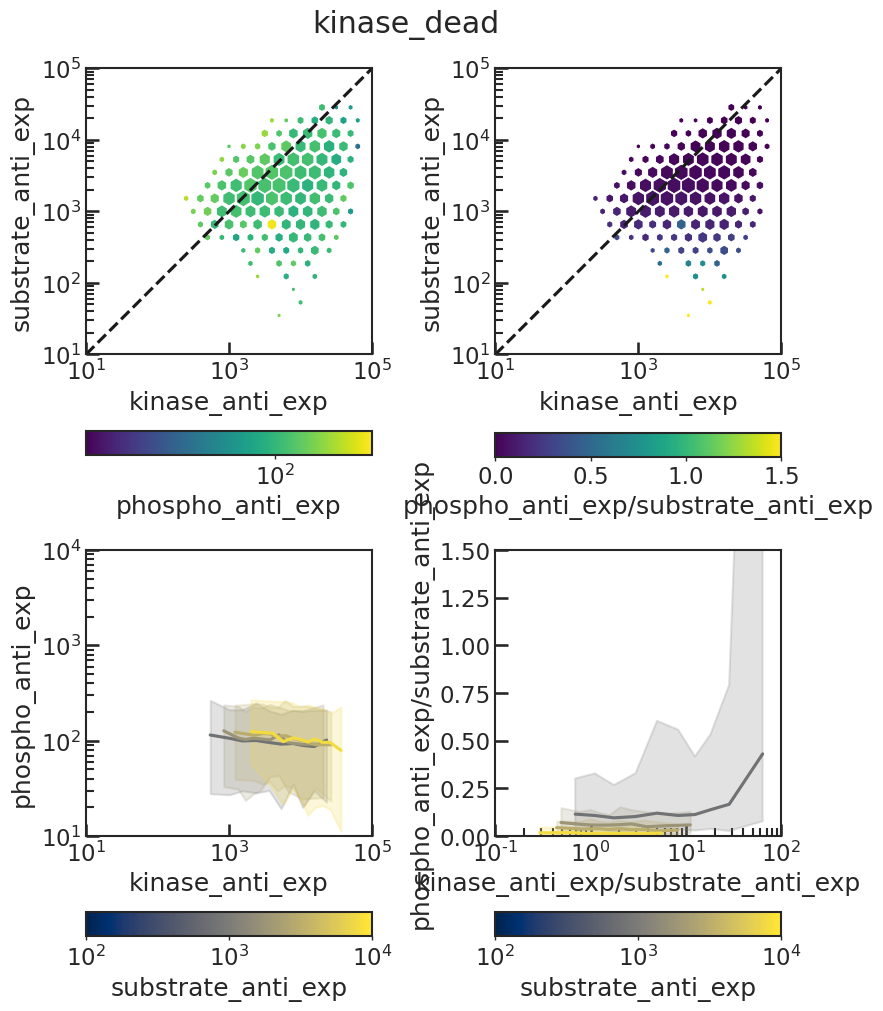

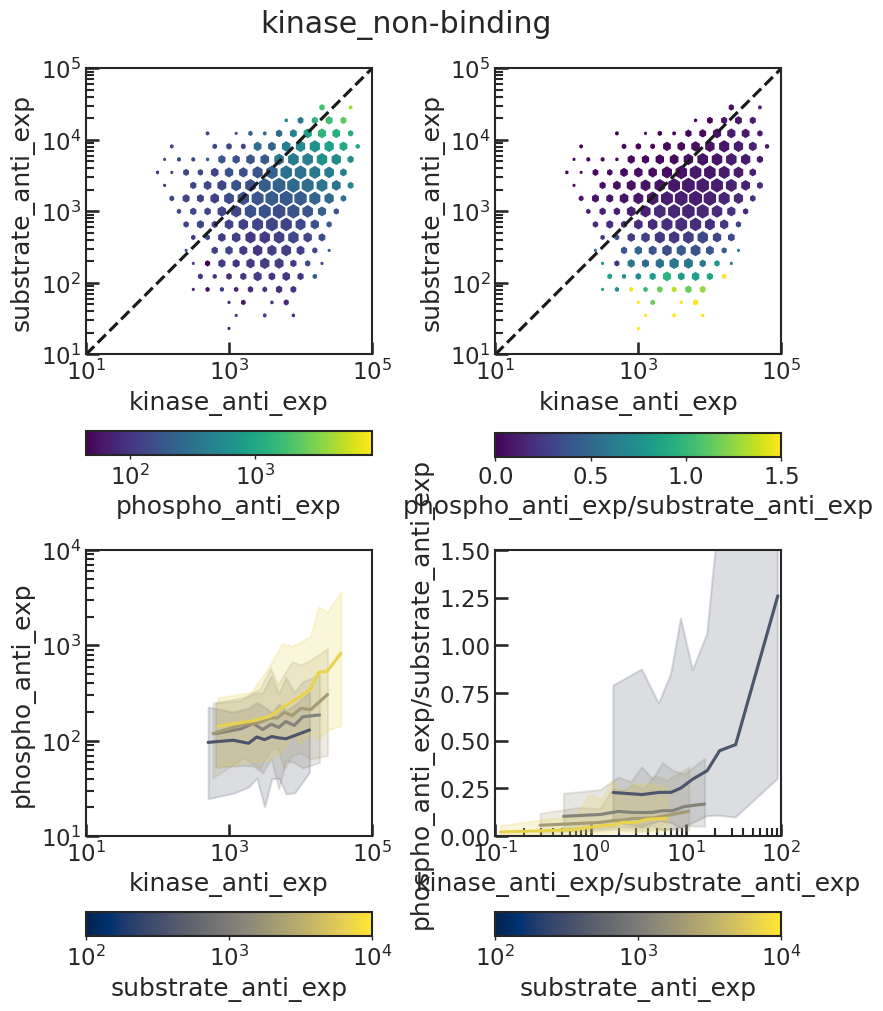

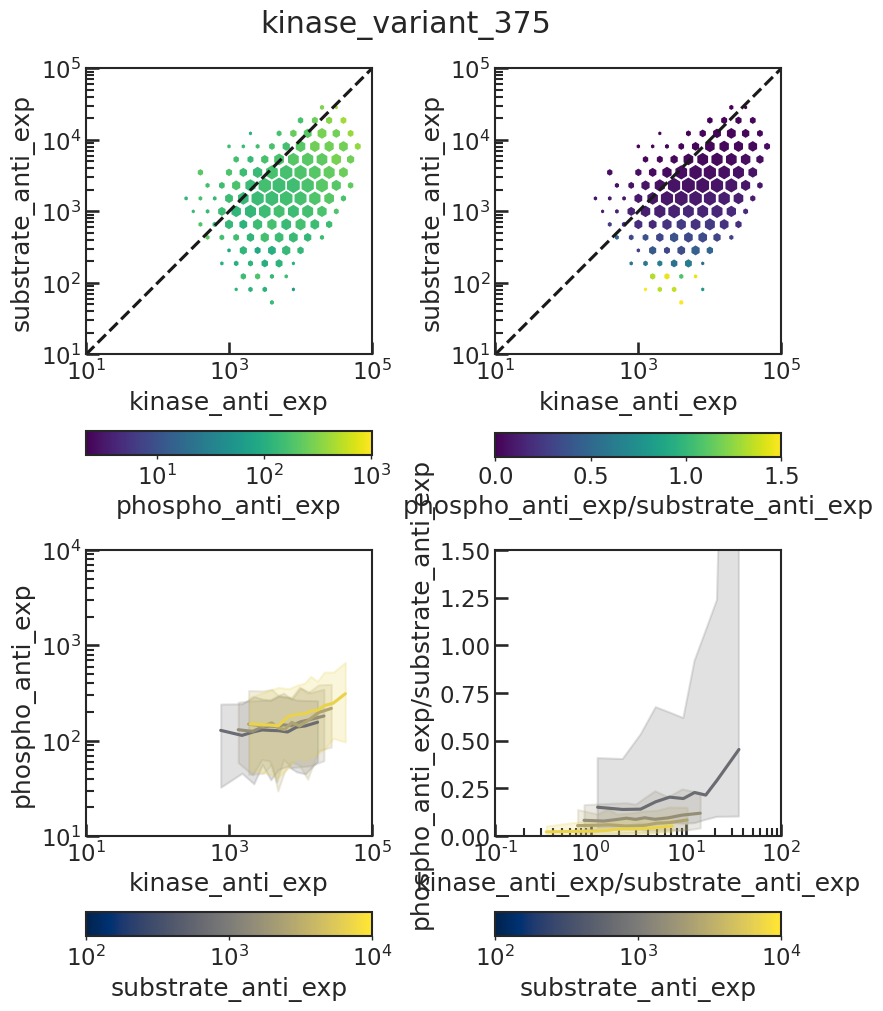

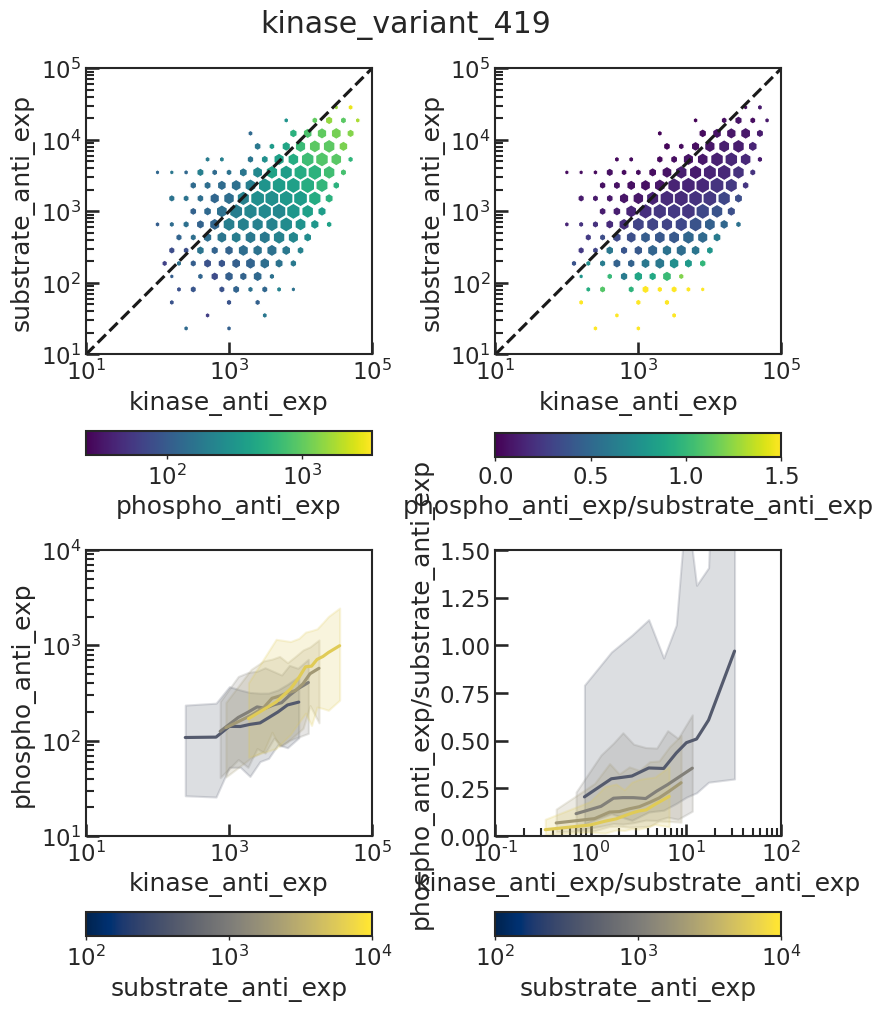

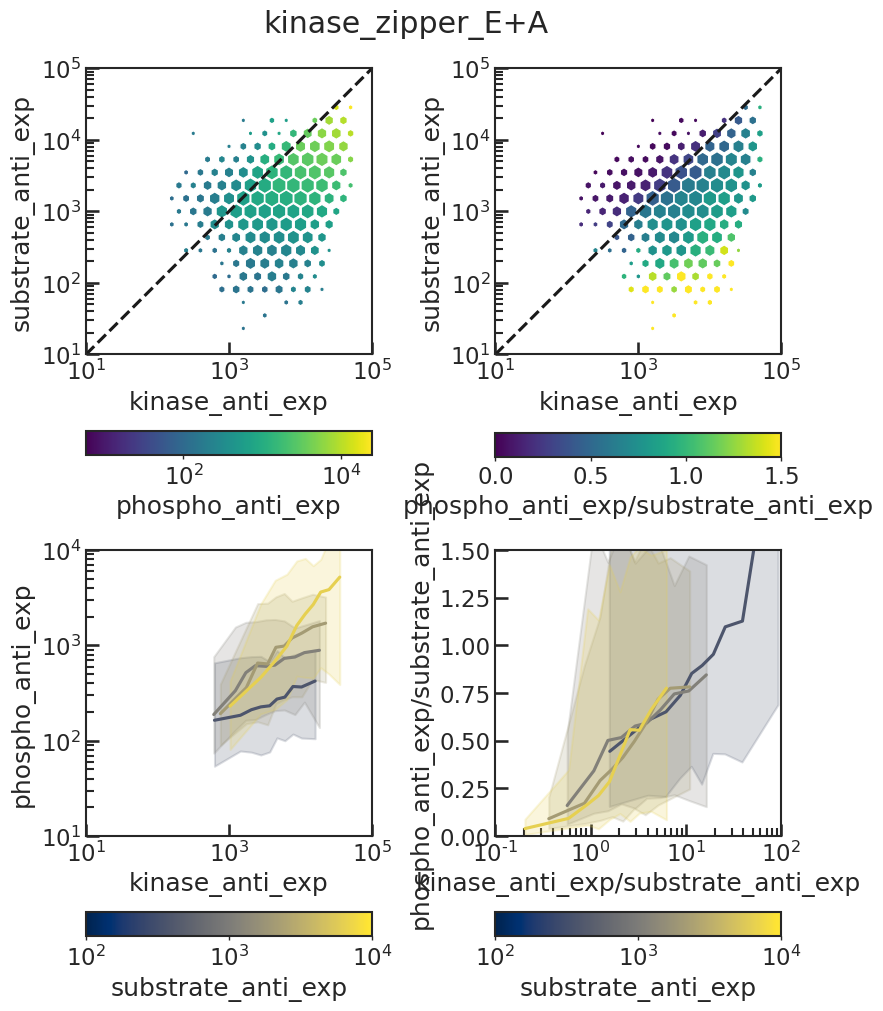

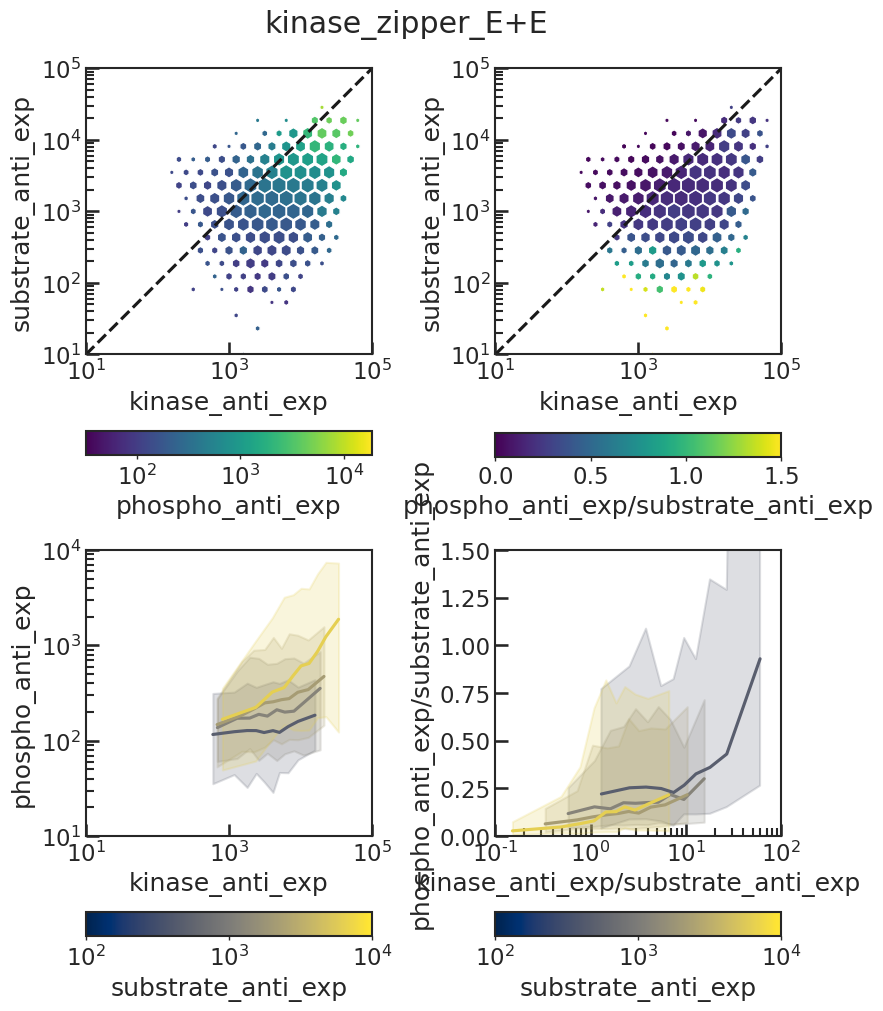

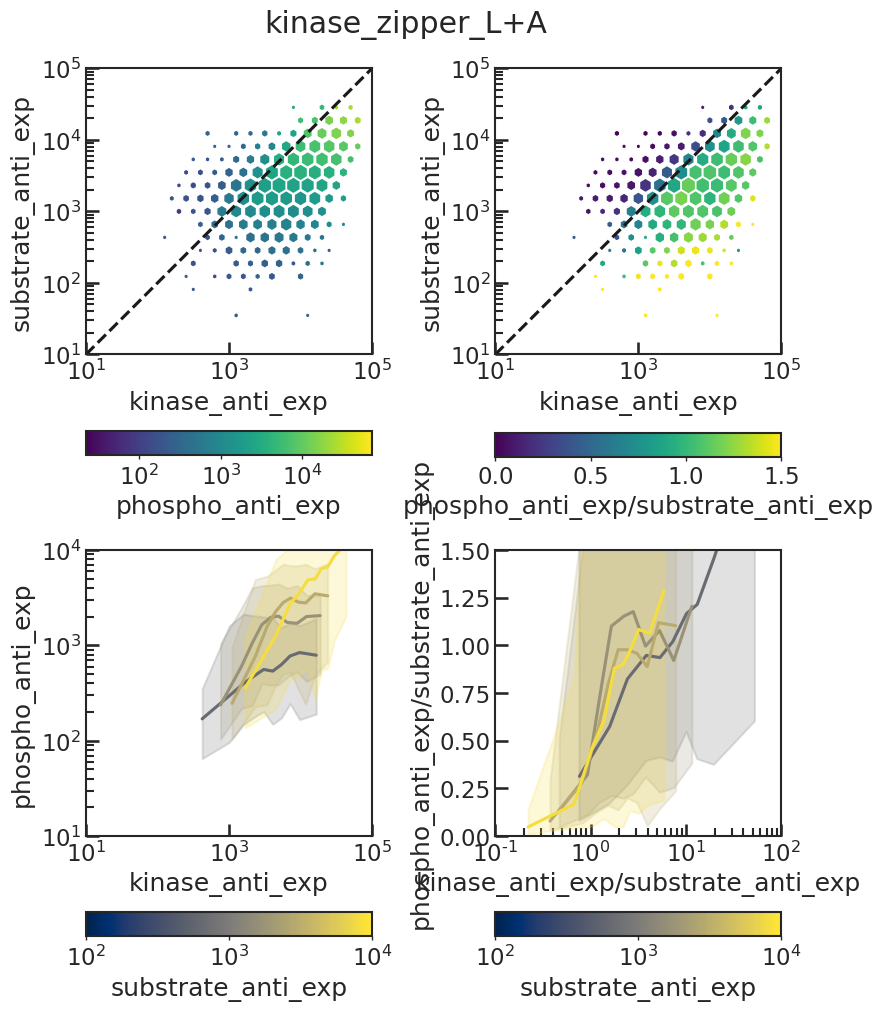

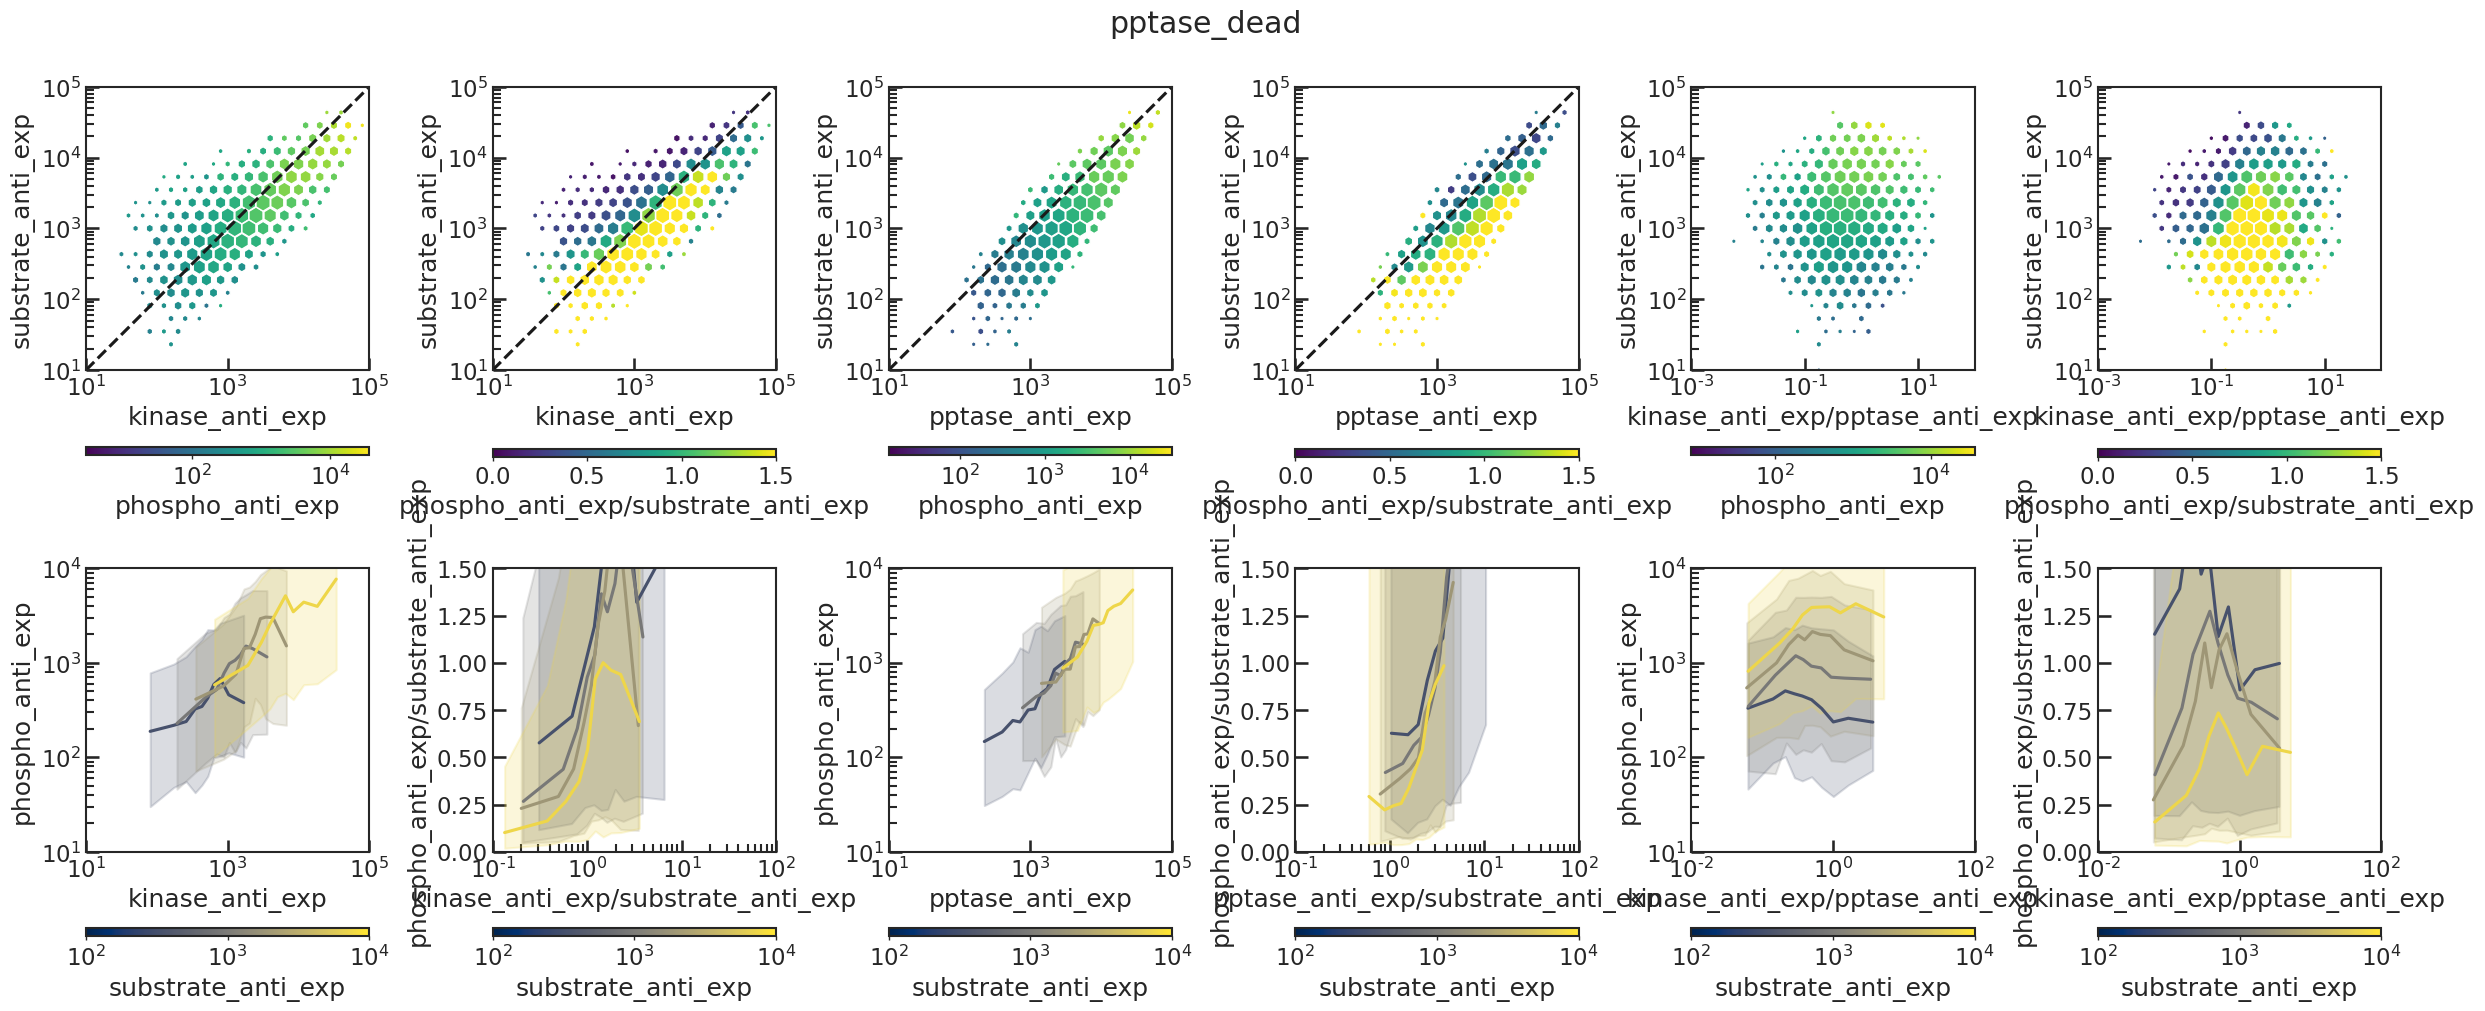

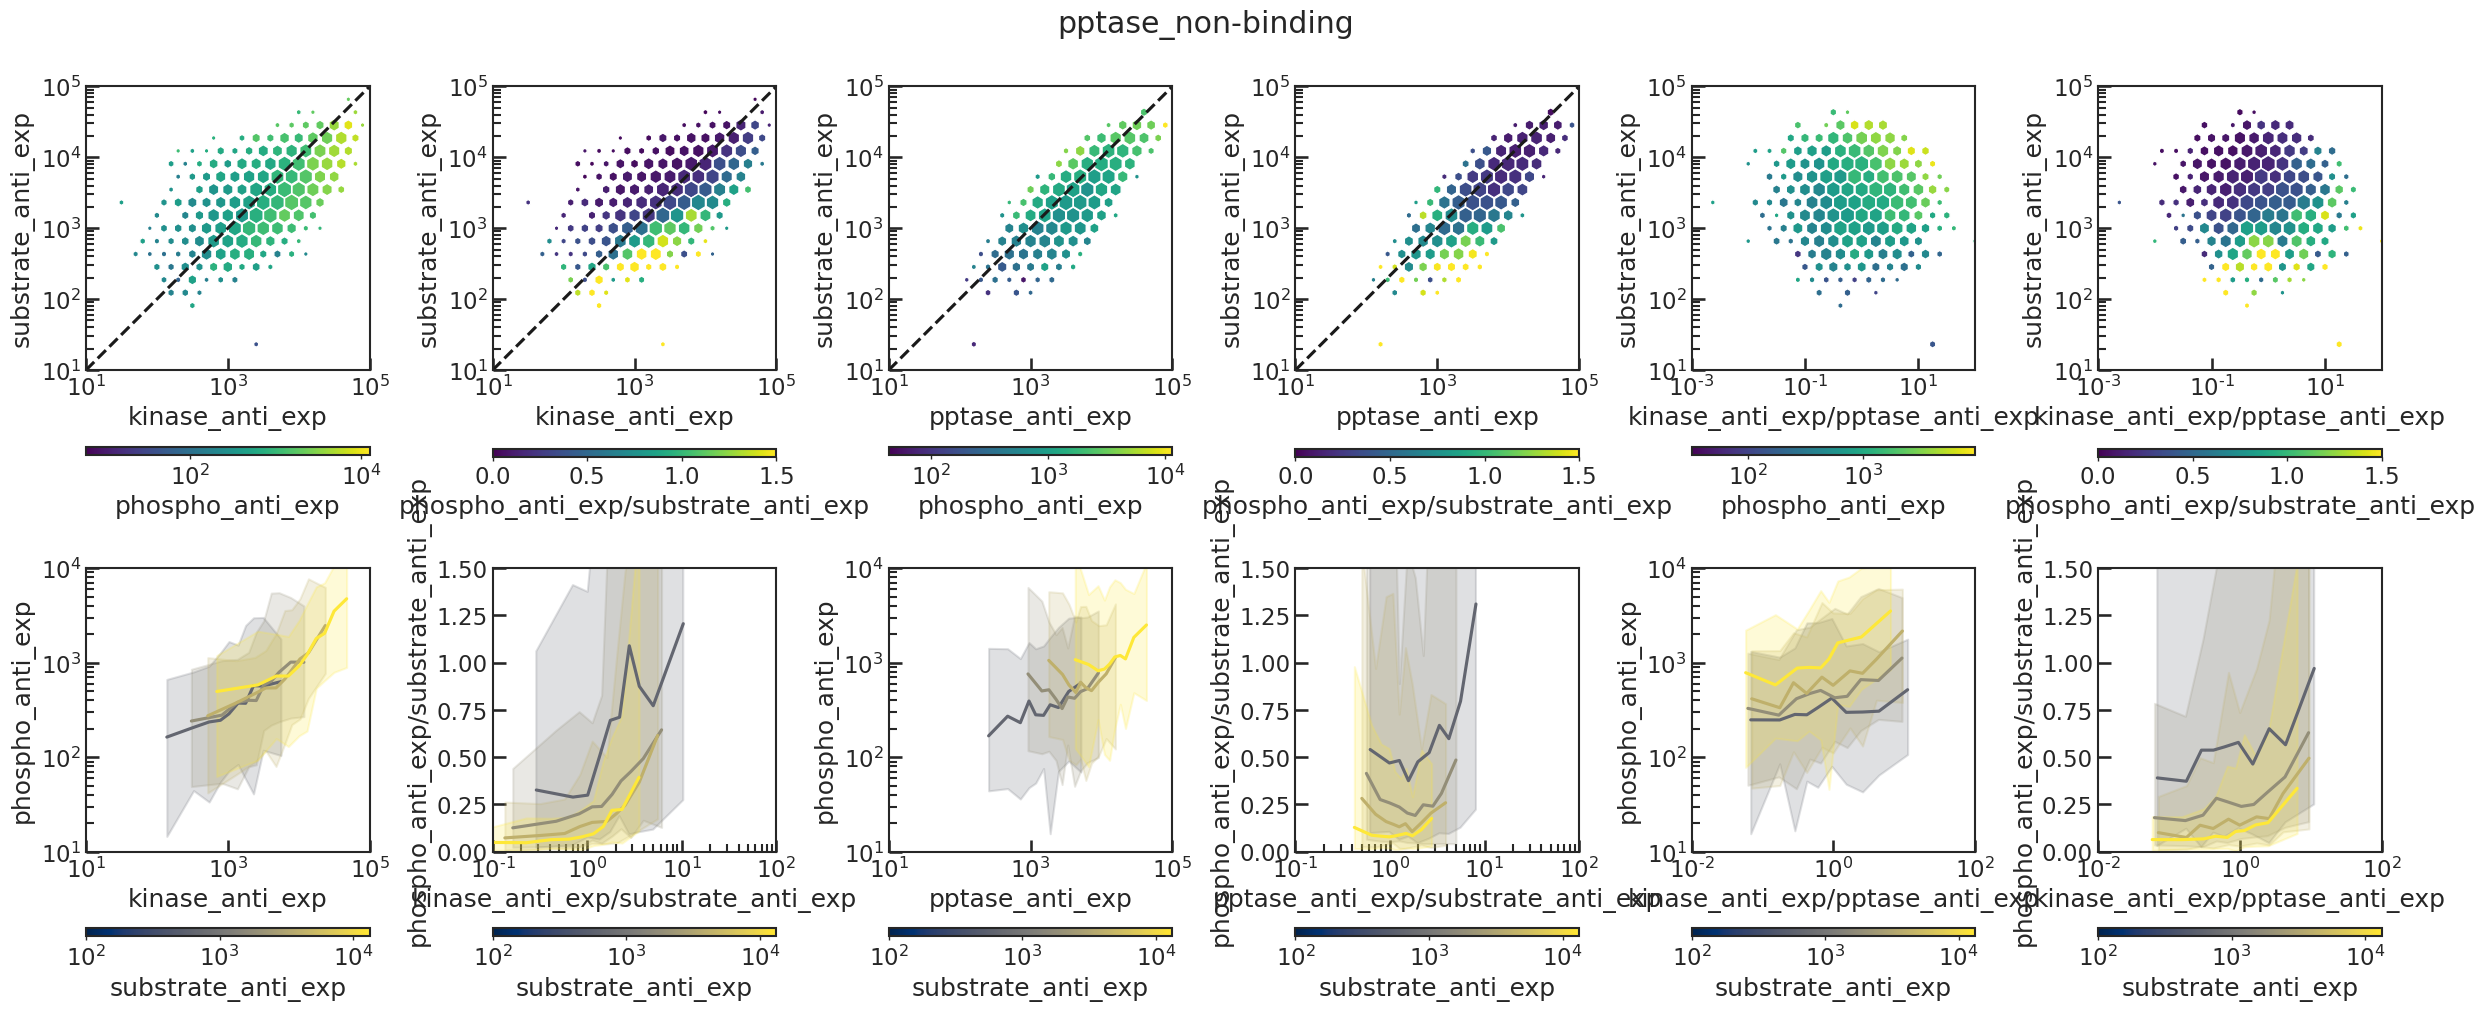

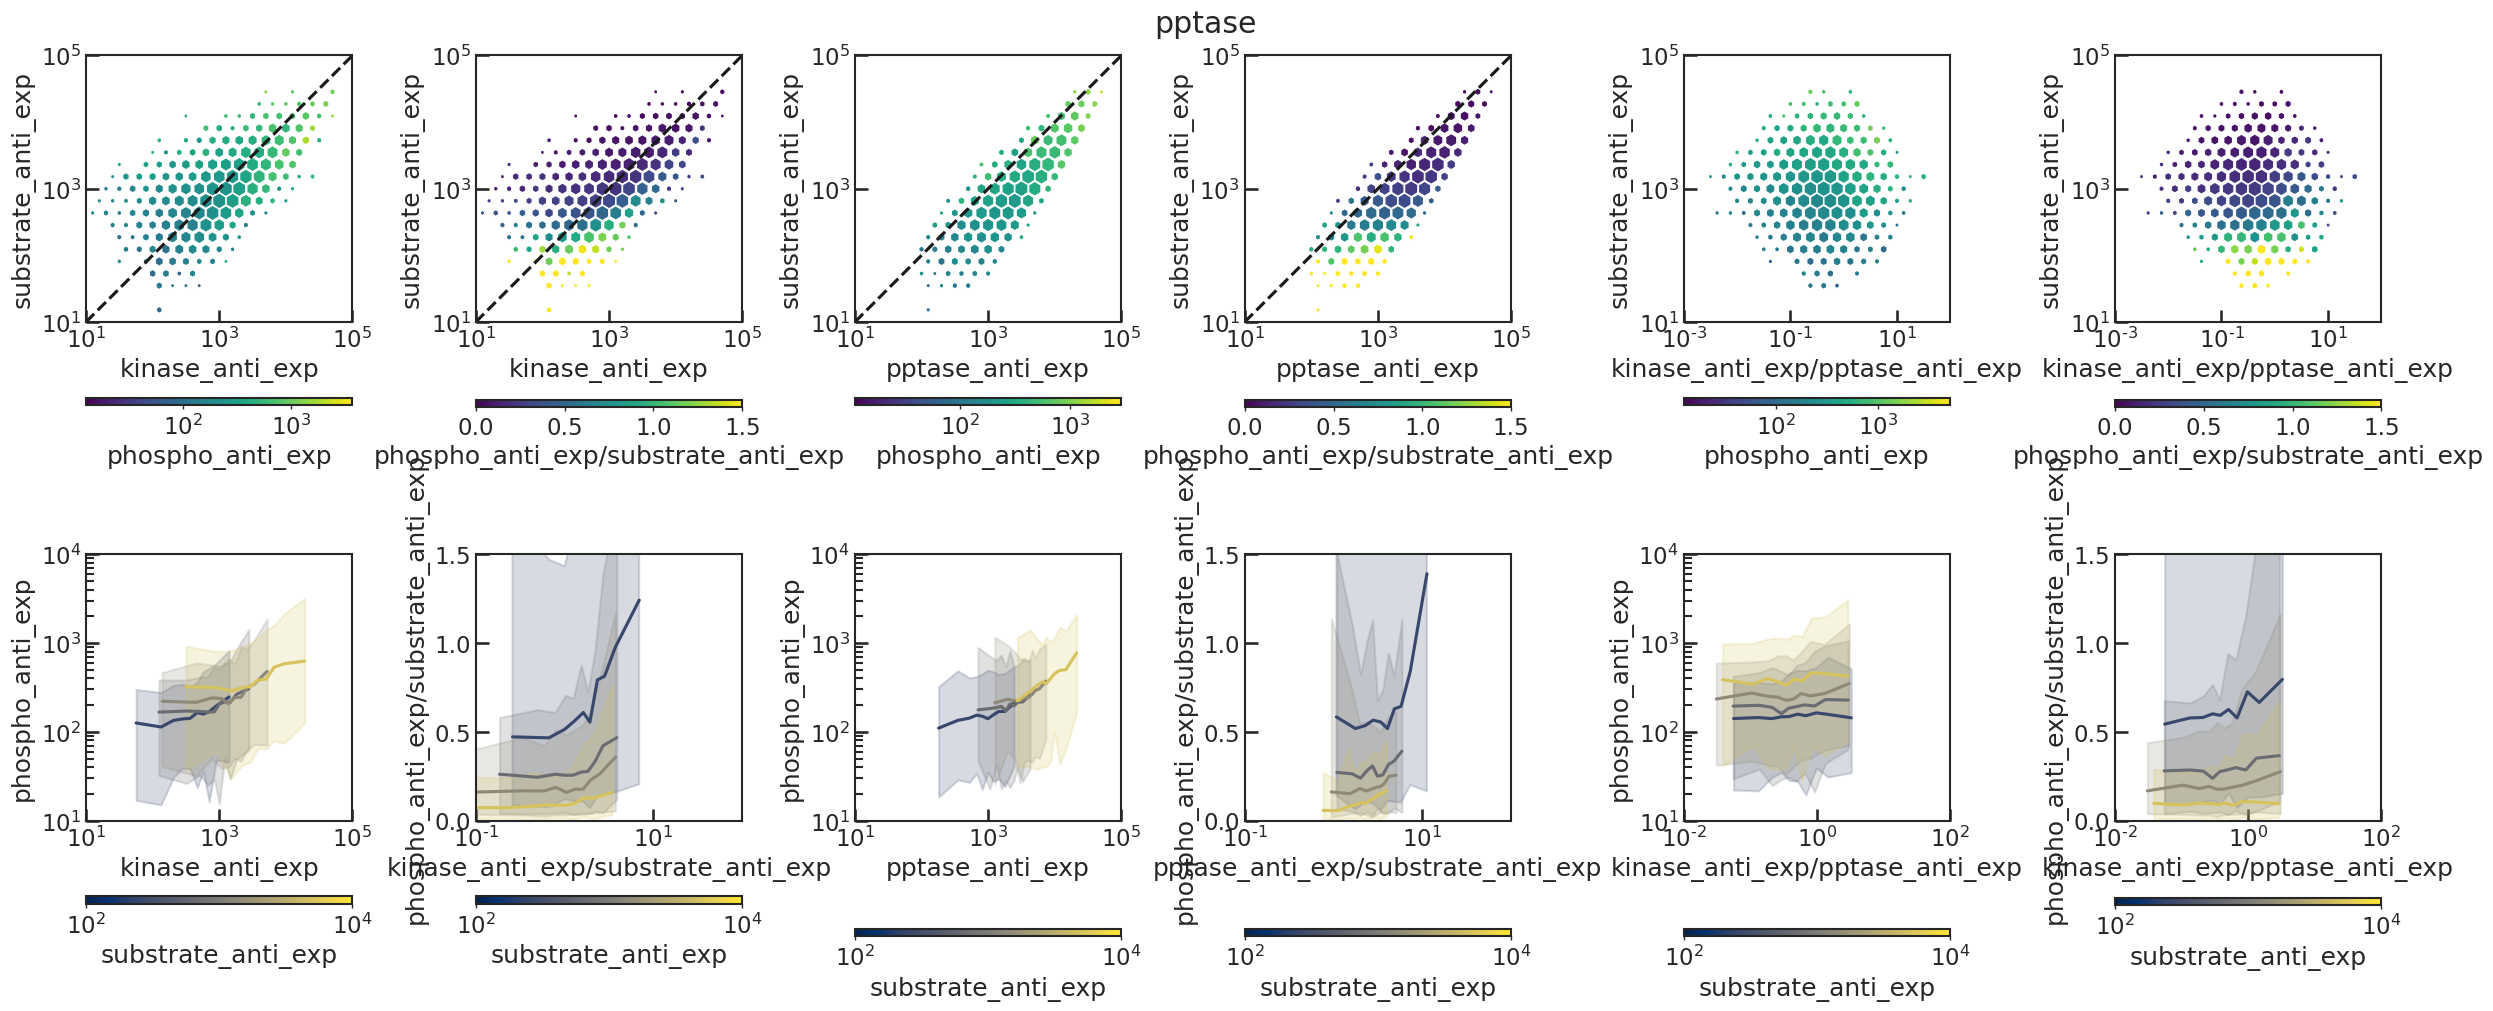

In [4]:
for exp_name, row in df_dataset_key.iterrows():
    
    if row['model'] == 'push' or row['model'] == "substrate_only" or row['model'] == "non-pplatable":
        fplot.plot_push_dataset_summary(df_data, exp_name)
    elif row['model'] == 'pushpull':
        fplot.plot_pushpull_dataset_summary(df_data, exp_name)
                

    

# Load noise model data and construct probability density functions

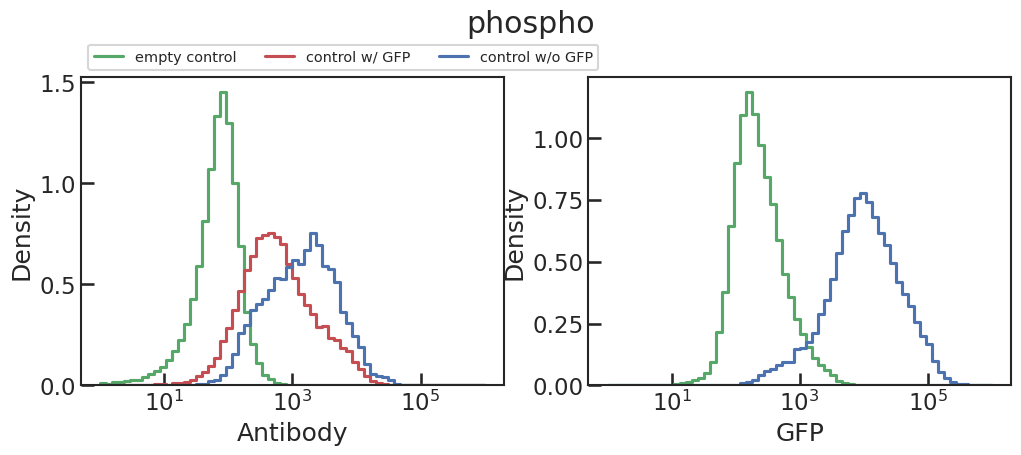

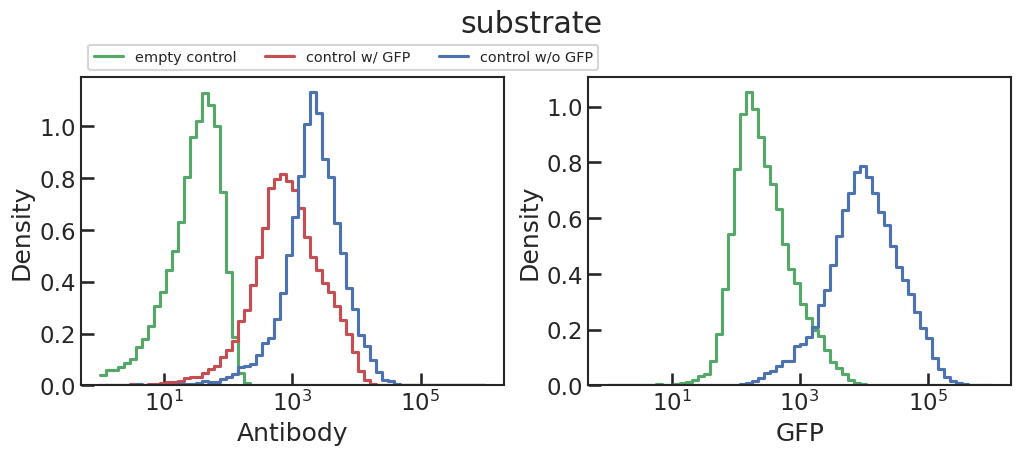

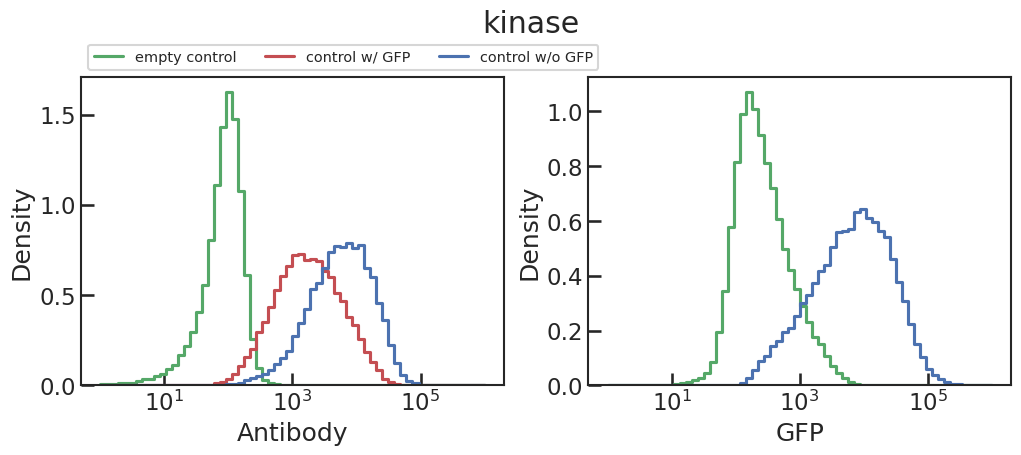

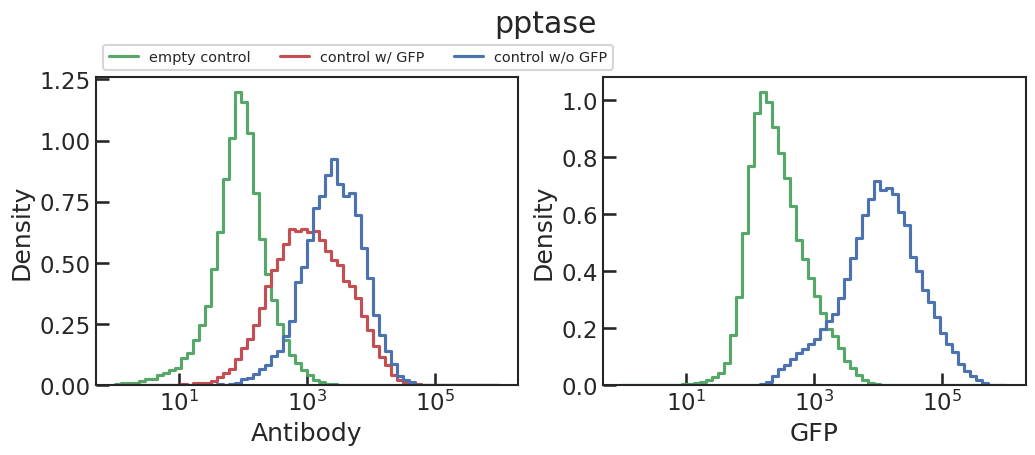

In [3]:
# points per bin
ppbin = 100

for c in components:
    
    # distribution of antibody values w/o GFP
    df = pd.read_csv("../data/{}/{}.csv".format(label, df_anti_noGFP2GFP_key.loc[c, 'file_name']))
    anti = df[df_anti_noGFP2GFP_key.loc[c, 'anti_col_name']].values
    anti = anti[anti > 0.0]
    noise_models[c]['anti_noGFP'] = noise.Density(anti, ppbin=ppbin)
    
    # distribution of antibody values w GFP and GFP for non-empty cells
    df = pd.read_csv("../data/{}/{}.csv".format(label, df_anti2GFP_key.loc[c, 'file_name']))    
    anti = df[df_anti2GFP_key.loc[c, 'anti_col_name']].values
    GFP = df[df_anti2GFP_key.loc[c, 'GFP_col_name']].values
    idx = (anti > 0.0) & (GFP > 0.0)
    noise_models[c]['anti'] = noise.Density(anti[idx], ppbin=ppbin)
    noise_models[c]['GFP'] = noise.Density(GFP[idx], ppbin=ppbin)
    
    # distribution of antibodies and GFP for empty cells
    df = pd.read_csv("../data/{}/{}.csv".format(label, df_anti2GFP_key.loc['empty_'+c, 'file_name']))
    anti = df[df_anti2GFP_key.loc['empty_'+c, 'anti_col_name']].values
    GFP = df[df_anti2GFP_key.loc['empty_'+c, 'GFP_col_name']].values
    idx = (anti > 0.0) & (GFP > 0.0)
    noise_models[c]['empty_anti'] = noise.Density(anti[idx], ppbin=ppbin)
    noise_models[c]['empty_GFP'] = noise.Density(GFP[idx], ppbin=ppbin)
    
    
    binrange = (0, 6)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)
    
    fig.suptitle(c, y=1.05)

    ax = axes[0, 0]
    
    
    
#     ax.hist(noise_models[c]['empty_anti'].bin_edges[:-1], bins=noise_models[c]['empty_anti'].bin_edges, weights=noise_models[c]['empty_anti'].density_logscale,
#            label="empty control", histtype='step', color='g')
#     ax.hist(noise_models[c]['anti'].bin_edges[:-1], bins=noise_models[c]['anti'].bin_edges, weights=noise_models[c]['anti'].density_logscale,
#            label="control w/ GFP", histtype='step', color='r')
#     ax.hist(noise_models[c]['anti_noGFP'].bin_edges[:-1], bins=noise_models[c]['anti_noGFP'].bin_edges, weights=noise_models[c]['anti_noGFP'].density_logscale,
#            label="control w/o GFP", histtype='step', color='b')
    
    sns.histplot(noise_models[c]['empty_anti'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', element='step', fill=False, color='g', stat='density')
    sns.histplot(noise_models[c]['anti'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='control w/ GFP', element='step', fill=False, color='r', stat='density')
    sns.histplot(noise_models[c]['anti_noGFP'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='control w/o GFP', element='step', fill=False, color='b', stat='density')


    ax.set_xscale('log')
    ax.set_xlabel("Antibody")

    
    ax.legend(loc='lower left', fontsize='xx-small', bbox_to_anchor=(0.0, 1.0), ncol=3)


    ax = axes[0, 1]


#     ax.hist(noise_models[c]['empty_GFP'].bin_edges[:-1], bins=noise_models[c]['empty_GFP'].bin_edges, weights=noise_models[c]['empty_GFP'].density_logscale,
#            label="empty control", histtype='step', color='g')
#     ax.hist(noise_models[c]['GFP'].bin_edges[:-1], bins=noise_models[c]['GFP'].bin_edges, weights=noise_models[c]['GFP'].density_logscale,
#            label="control", histtype='step', color='b')
    
    sns.histplot(noise_models[c]['empty_GFP'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', element='step', fill=False, color='g', stat='density')
    sns.histplot(noise_models[c]['GFP'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='control', element='step', fill=False, color='b', stat='density')


    ax.set_xscale('log')
    ax.set_xlabel("GFP")


    plt.show()
    
    

# Noise models converting antibody measurements to GFP measurements

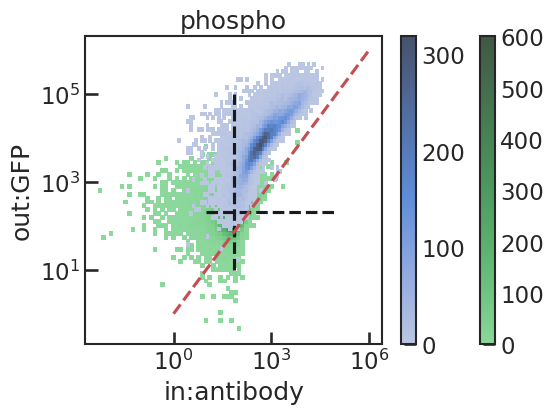

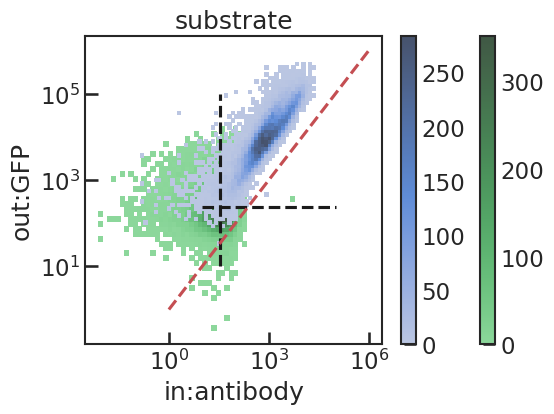

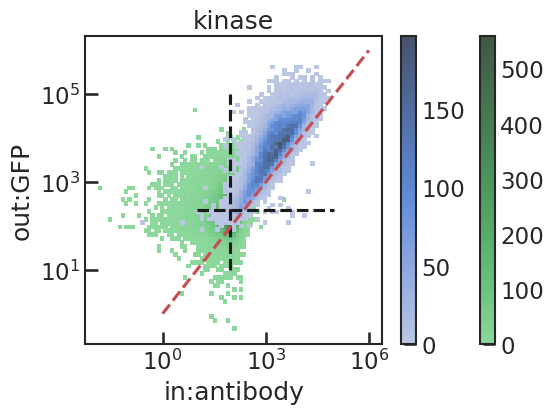

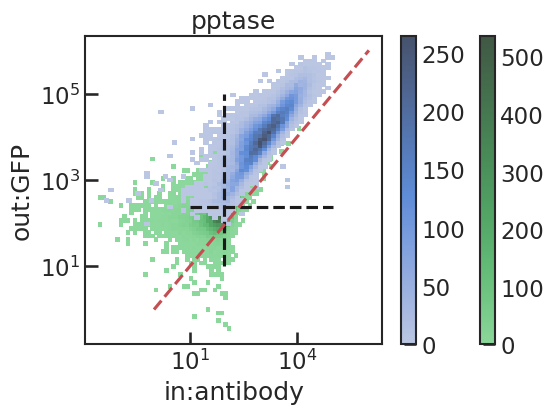

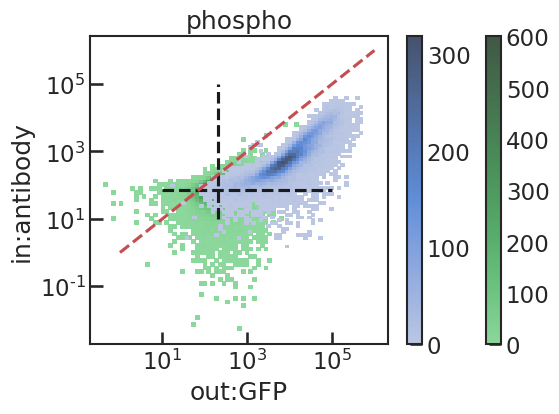

In [4]:

# points per bin
ppbin = 10

for c in components:
        
    noise_models[c]['empty_anti2GFP'] =  noise.RandomConditionalNoise(noise_models[c]['empty_anti'].get_data(), 
                                            noise_models[c]['empty_GFP'].get_data(), ppbin=ppbin, verbose=False)
    
    noise_models[c]['anti2GFP'] =  noise.RandomConditionalNoise(noise_models[c]['anti'].get_data(), 
                                            noise_models[c]['GFP'].get_data(), ppbin=ppbin, verbose=False)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    noise_models[c]['empty_anti2GFP'].plot(ax, color='g')
    noise_models[c]['anti2GFP'].plot(ax)

    ax.set_title(c)

    ax.vlines(10**np.median(np.log10(noise_models[c]['empty_anti2GFP'].get_in_data())), ymin=1e1, ymax=1e5, color='k', ls='--')

    ax.hlines(10**np.median(np.log10(noise_models[c]['empty_anti2GFP'].get_out_data())), xmin=1e1, xmax=1e5, color='k', ls='--')

    ax.set_ylabel('out:GFP')
    ax.set_xlabel('in:antibody')

    ax.plot(np.linspace(1e0, 1e6), np.linspace(1e0, 1e6), 'r--')


    plt.show()
    
# reverse noise model for pplated substrate

c = 'phospho'
noise_models[c]['empty_GFP2anti'] =   noise.RandomConditionalNoise(noise_models[c]['empty_GFP'].get_data(), 
                                            noise_models[c]['empty_anti'].get_data(), ppbin=ppbin, verbose=False)

df = pd.read_csv("../data/{}/{}.csv".format(label, df_anti2GFP_key.loc[c, 'file_name']))
noise_models[c]['GFP2anti'] =  noise.RandomConditionalNoise(noise_models[c]['GFP'].get_data(), 
                                            noise_models[c]['anti'].get_data(), ppbin=ppbin, verbose=False)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
noise_models[c]['empty_GFP2anti'].plot(ax, color='g')
noise_models[c]['GFP2anti'].plot(ax)

ax.set_title(c)

ax.vlines(10**np.median(np.log10(noise_models[c]['empty_GFP2anti'].get_in_data())), ymin=1e1, ymax=1e5, color='k', ls='--')

ax.hlines(10**np.median(np.log10(noise_models[c]['empty_GFP2anti'].get_out_data())), xmin=1e1, xmax=1e5, color='k', ls='--')

ax.set_xlabel('out:GFP')
ax.set_ylabel('in:antibody')

ax.plot(np.linspace(1e0, 1e6), np.linspace(1e0, 1e6), 'r--')


plt.show()
    


# Noise models converting antibody measurements without GFP to antibody measurements with GFP

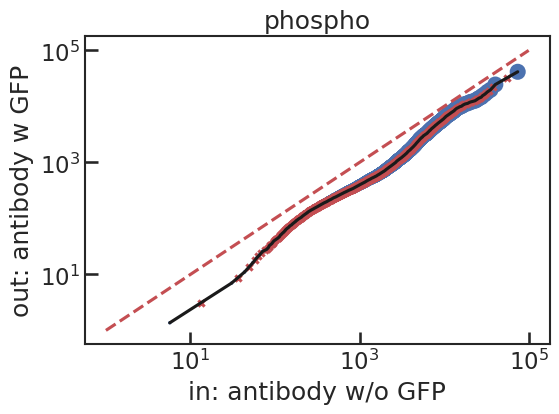

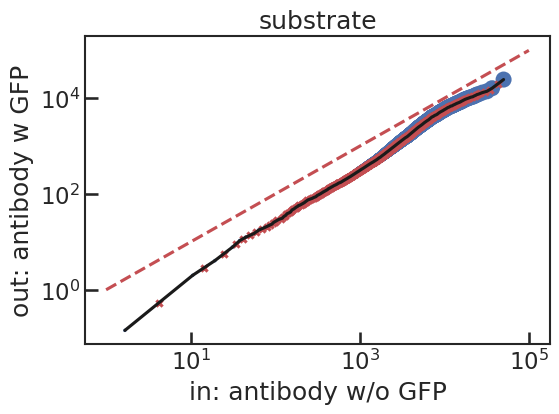

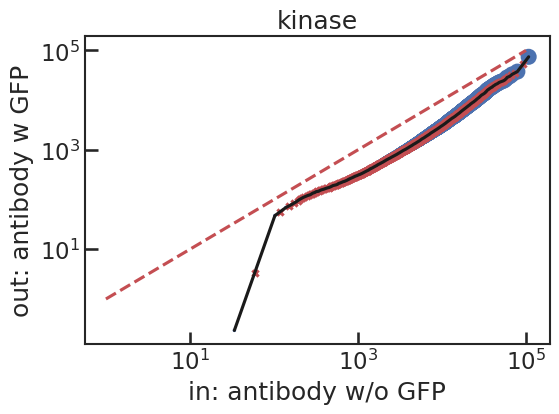

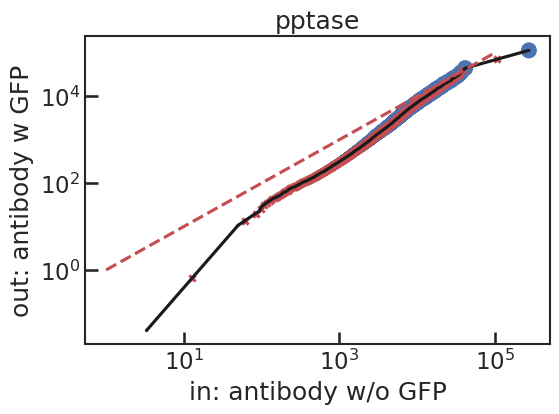

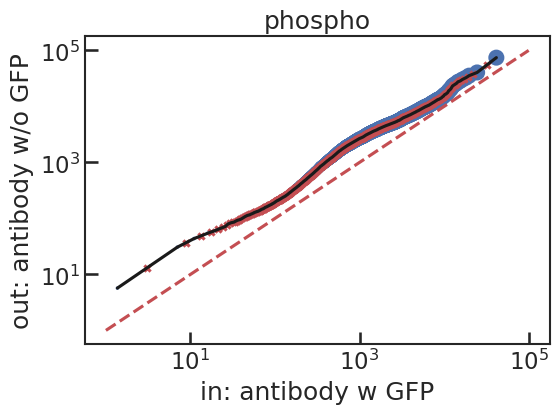

In [5]:
# number of percentile bins to consider
nbins = 1000

for c in components:
    
    noise_models[c]['anti2antiwGFP'] = noise.PercentileNoise(noise_models[c]['anti_noGFP'].get_data(), 
                                               noise_models[c]['anti'].get_data(), nbins=nbins, verbose=True)
    
        
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    noise_models[c]['anti2antiwGFP'].plot(ax)

    ax.set_title(c)

    ax.plot(np.linspace(1e0, 1e5), np.linspace(1e0, 1e5), 'r--')

    ax.set_ylabel("out: antibody w GFP")
    ax.set_xlabel("in: antibody w/o GFP")


    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.show()

    
# reverse noise model for pplated substrate

c = 'phospho'
noise_models[c]['antiwGFP2anti'] = noise.PercentileNoise(noise_models[c]['anti'].get_data(), 
                                               noise_models[c]['anti_noGFP'].get_data(), nbins=nbins, verbose=True)
    

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
noise_models[c]['antiwGFP2anti'].plot(ax)

ax.set_title(c)

ax.plot(np.linspace(1e0, 1e5), np.linspace(1e0, 1e5), 'r--')

ax.set_ylabel("out: antibody w/o GFP")
ax.set_xlabel("in: antibody w GFP")


ax.set_xscale('log')
ax.set_yscale('log')

plt.show()



# Calculate probability of being empty cell based off antibody values

In [6]:
for c in components:
    df_data[c+'_prob_empty'] = 0.0


if antibody_shift:
    anti_label = 'anti_noGFP'
else:
    anti_label = 'anti'

for exp_name, row in df_dataset_key.iterrows():
    
    print(exp_name)
        
    df_tmp = df_data.query("exp_name==@exp_name").dropna()
    
    for c in components:
        
        if row['model'] != 'pushpull' and c=='pptase':
            continue
        
        p_empty = noise_models[c]['empty_anti'].get_density(df_data.loc[df_tmp.index, c+'_anti_exp'], log_scale=False)
        p_nempty =noise_models[c][anti_label].get_density(df_data.loc[df_tmp.index, c+'_anti_exp'], log_scale=False)
        idx = (p_empty > 0.0) | (p_nempty > 0.0)    
        df_data.loc[df_tmp.index[idx], c+'_prob_empty'] = p_empty[idx] / (p_empty[idx] + p_nempty[idx])
        df_data.loc[df_tmp.index[~idx], c+'_prob_empty'] = np.nan
    
    
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
#     ax1.scatter(df_data.loc[df_tmp.index, 'SpT_anti_exp'], p_empty, s=4)
#     ax1.scatter(df_data.loc[df_tmp.index, 'SpT_anti_exp'], p_nempty, s=4)
    
#     ax1.set_xscale('log')
    
    
#     ax2.scatter(df_data.loc[df_tmp.index, 'SpT_anti_exp'], q_empty, s=4)
#     ax2.scatter(df_data.loc[df_tmp.index, 'SpT_anti_exp'], 1-q_empty, s=4)
#     ax2.set_xscale('log')
    
    
#     plt.show()
    
display(df_data)

substrate_only
non-pplatable
kinase_dead
kinase_non-binding
kinase_variant_375
kinase_variant_419
kinase_zipper_E+A
kinase_zipper_E+E
kinase_zipper_L+A
pptase_dead
pptase_non-binding
pptase


substrate_anti_exp  phospho_anti_exp  \
exp_name       cell_index                                         
substrate_only 0                  2212.525146        133.354218   
               1                  4954.513184        112.124626   
               2                  3487.114746        119.673706   
               3                   253.888428        100.082169   
               4                   584.118408         39.466415   
...                                       ...               ...   
pptase         15453               605.925781        116.375717   
               15454              3005.479980          3.798526   
               15455               140.026718        260.147644   
               15456               174.096863        169.258682   
               15457               363.897980        246.208633   

                           kinase_anti_exp  pptase_anti_exp  \
exp_name       cell_index                                     
substrate_only 0                 79.178284     1.000000e-08   
               1                 86.252625     1.000000e-08   
               2                 10.157516     1.000000e-08   
               3                 96.854454     1.000000e-08   
               4                118.221375     1.000000e-08   
...                                    ...              ...   
pptase         15453            585.051575     1.200013e+03   
               15454           7184.776367     4.150368e+03   
               15455            658.204529     5.767077e+02   
               15456            372.268127     7.306846e+02   
               15457            529.578430     9.265865e+02   

                           phospho_prob_empty  substrate_prob_empty  \
exp_name       cell_index                                             
substrate_only 0                     0.835467              0.003507   
               1                     0.924583              0.016788   
               2                     0.919016              0.009055   
               3                     0.946850              0.005789   
               4                     0.983930              0.005091   
...                                       ...                   ...   
pptase         15453                 0.928989              0.005091   
               15454                 1.000000              0.006101   
               15455                 0.347379              0.702666   
               15456                 0.669715              0.004919   
               15457                 0.291574              0.004794   

                           kinase_prob_empty  pptase_prob_empty  
exp_name       cell_index                                        
substrate_only 0                    0.994416           0.000000  
               1                    0.993424           0.000000  
               2                    1.000000           0.000000  
               3                    0.992733           0.000000  
               4                    0.992449           0.000000  
...                                      ...                ...  
pptase         15453                0.010408           0.039166  
               15454                0.000000           0.003252  
               15455                0.010408           0.292457  
               15456                0.453276           0.194159  
               15457                0.010423           0.112482  

[139743 rows x 8 columns]

How to calculate prob empty or not empty -> use probability densities

1. anti2GFP and GFP2anti (for just phospho) for both empty and non empty
2. anti2antiwGFP and antiwGFP2anti (for just phospho) for just non empty
3. probaility densities of all components

$q_{empty} = \frac{p(anti|empty)}{p(anti|empty) + p(anti| not empty)}$ (w/o GFP)

$GFP = q_{empty} * GFP_{empty}(anti) + (1-q_{empty}) * GFP(shift(anti))$


$q_{empty} = \frac{p(GFP|empty)}{p(GFP|empty) + p(GFP| not empty)}$ 

$anti = q_{empty} * anti_{empty}(GFP) + (1-q_{empty}) * shift^{-1}(anti(GFP))$



# Convert antibody measurements to GFP units

In [7]:
for c in components:
    df_data[c+'_GFP_infer'] = 0.0
    df_data[c+'_conc_infer'] = 0.0

for exp_name, row in df_dataset_key.iterrows():
    
    print(exp_name)
        
    df_tmp = df_data.query("exp_name==@exp_name").dropna()
    
    for c in components:
        
        if row['model'] != 'pushpull' and c=='pptase':
            continue
    
        q_empty = df_data.loc[df_tmp.index, c+'_prob_empty'].values

        if antibody_shift:
            anti_wGFP = noise_models[c]['anti2antiwGFP'].transform(df_data.loc[df_tmp.index, c+'_anti_exp'])
        else:
            anti_wGFP = df_data.loc[df_tmp.index, c+'_anti_exp']

        idx = q_empty == 1.0
        df_data.loc[df_tmp.index[idx], c+'_GFP_infer'] = noise_models[c]['empty_anti2GFP'].transform(df_data.loc[df_tmp.index[idx], c+'_anti_exp'])

        idx = q_empty == 0.0
        df_data.loc[df_tmp.index[idx], c+'_GFP_infer'] = noise_models[c]['anti2GFP'].transform(anti_wGFP[idx])

        idx = (q_empty > 0.0) & (q_empty < 1.0)
        df_data.loc[df_tmp.index[idx], c+'_GFP_infer'] = q_empty[idx]*noise_models[c]['empty_anti2GFP'].transform(df_data.loc[df_tmp.index[idx], c+'_anti_exp']) \
                                                                + (1-q_empty[idx])*noise_models[c]['anti2GFP'].transform(anti_wGFP[idx])
        
        
        df_data.loc[df_tmp.index, c+'_conc_infer'] = np.maximum(df_data.loc[df_tmp.index, c+'_GFP_infer'] - noise_models[c]['empty_GFP'].median, 0.0)


display(df_data)

substrate_only
non-pplatable
kinase_dead
kinase_non-binding
kinase_variant_375
kinase_variant_419
kinase_zipper_E+A
kinase_zipper_E+E
kinase_zipper_L+A
pptase_dead
pptase_non-binding
pptase


substrate_anti_exp  phospho_anti_exp  \
exp_name       cell_index                                         
substrate_only 0                  2212.525146        133.354218   
               1                  4954.513184        112.124626   
               2                  3487.114746        119.673706   
               3                   253.888428        100.082169   
               4                   584.118408         39.466415   
...                                       ...               ...   
pptase         15453               605.925781        116.375717   
               15454              3005.479980          3.798526   
               15455               140.026718        260.147644   
               15456               174.096863        169.258682   
               15457               363.897980        246.208633   

                           kinase_anti_exp  pptase_anti_exp  \
exp_name       cell_index                                     
substrate_only 0                 79.178284     1.000000e-08   
               1                 86.252625     1.000000e-08   
               2                 10.157516     1.000000e-08   
               3                 96.854454     1.000000e-08   
               4                118.221375     1.000000e-08   
...                                    ...              ...   
pptase         15453            585.051575     1.200013e+03   
               15454           7184.776367     4.150368e+03   
               15455            658.204529     5.767077e+02   
               15456            372.268127     7.306846e+02   
               15457            529.578430     9.265865e+02   

                           phospho_prob_empty  substrate_prob_empty  \
exp_name       cell_index                                             
substrate_only 0                     0.835467              0.003507   
               1                     0.924583              0.016788   
               2                     0.919016              0.009055   
               3                     0.946850              0.005789   
               4                     0.983930              0.005091   
...                                       ...                   ...   
pptase         15453                 0.928989              0.005091   
               15454                 1.000000              0.006101   
               15455                 0.347379              0.702666   
               15456                 0.669715              0.004919   
               15457                 0.291574              0.004794   

                           kinase_prob_empty  pptase_prob_empty  \
exp_name       cell_index                                         
substrate_only 0                    0.994416           0.000000   
               1                    0.993424           0.000000   
               2                    1.000000           0.000000   
               3                    0.992733           0.000000   
               4                    0.992449           0.000000   
...                                      ...                ...   
pptase         15453                0.010408           0.039166   
               15454                0.000000           0.003252   
               15455                0.010408           0.292457   
               15456                0.453276           0.194159   
               15457                0.010423           0.112482   

                           phospho_GFP_infer  phospho_conc_infer  \
exp_name       cell_index                                          
substrate_only 0                  552.593118          349.705895   
               1                  370.370807          167.483585   
               2                  131.236836            0.000000   
               3                 1588.078290         1385.191068   
               4                  136.507721            0.000000   
...                                      ...                 ..

# Plot each distribution

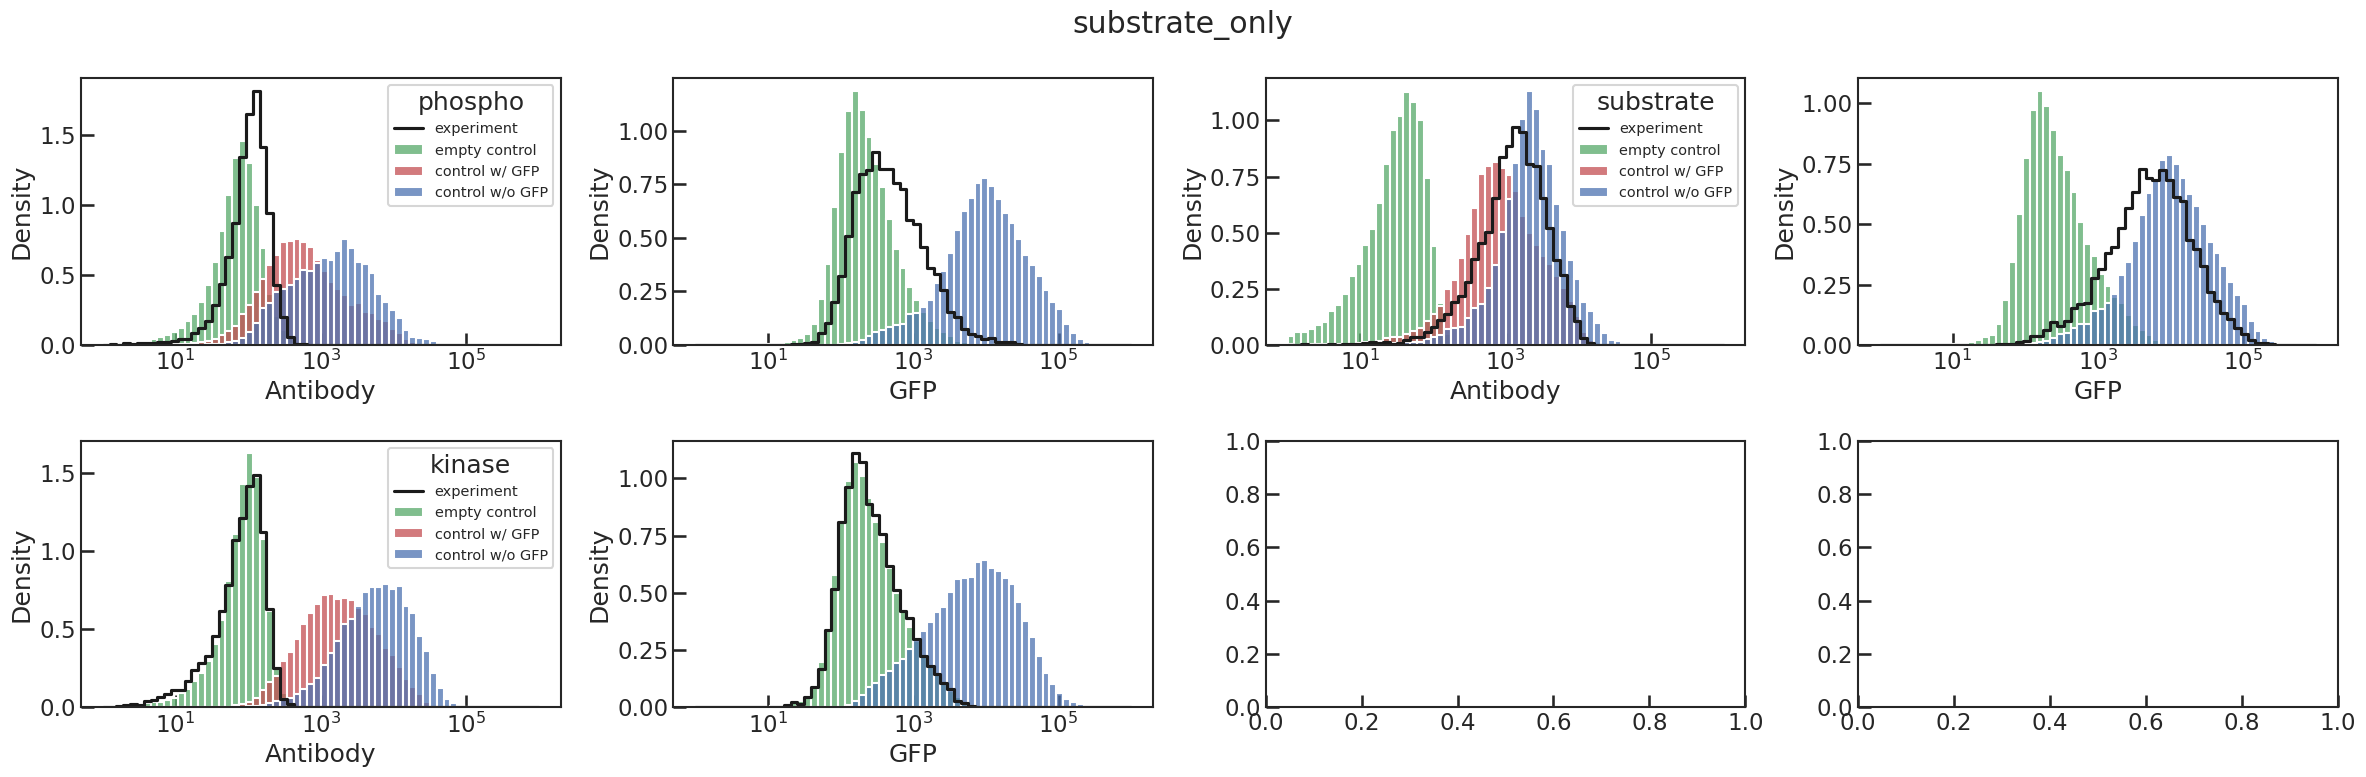

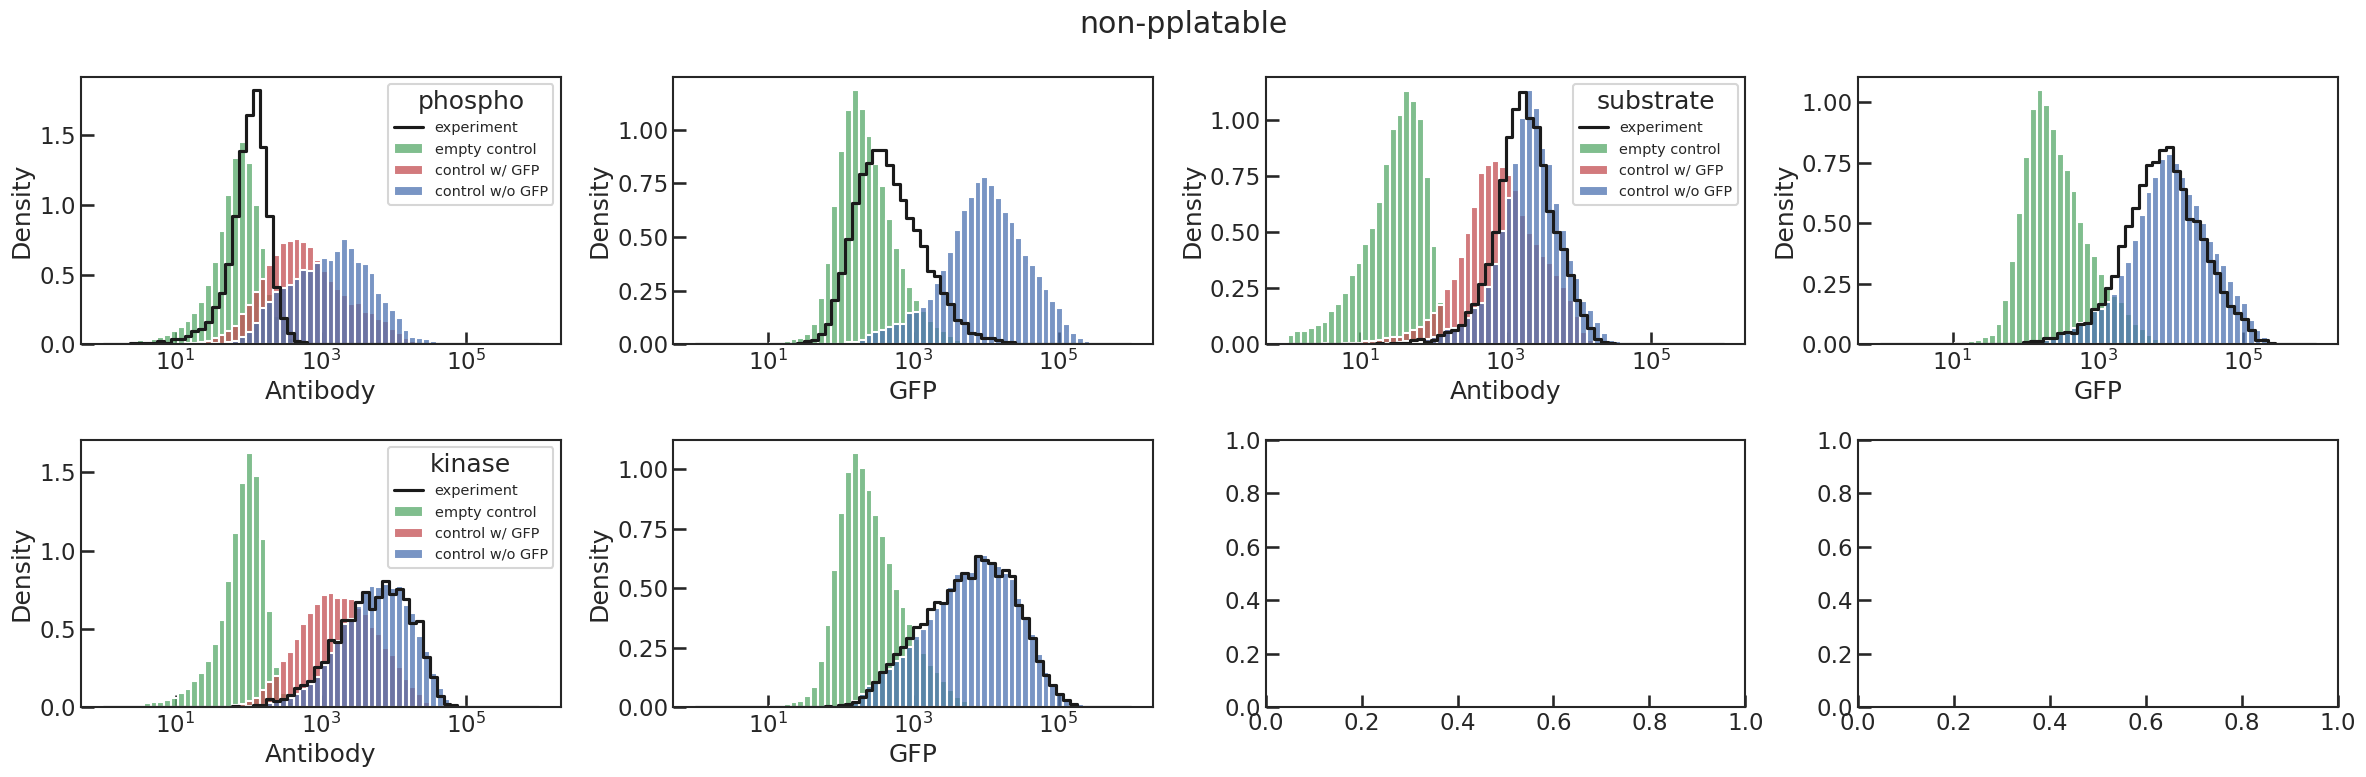

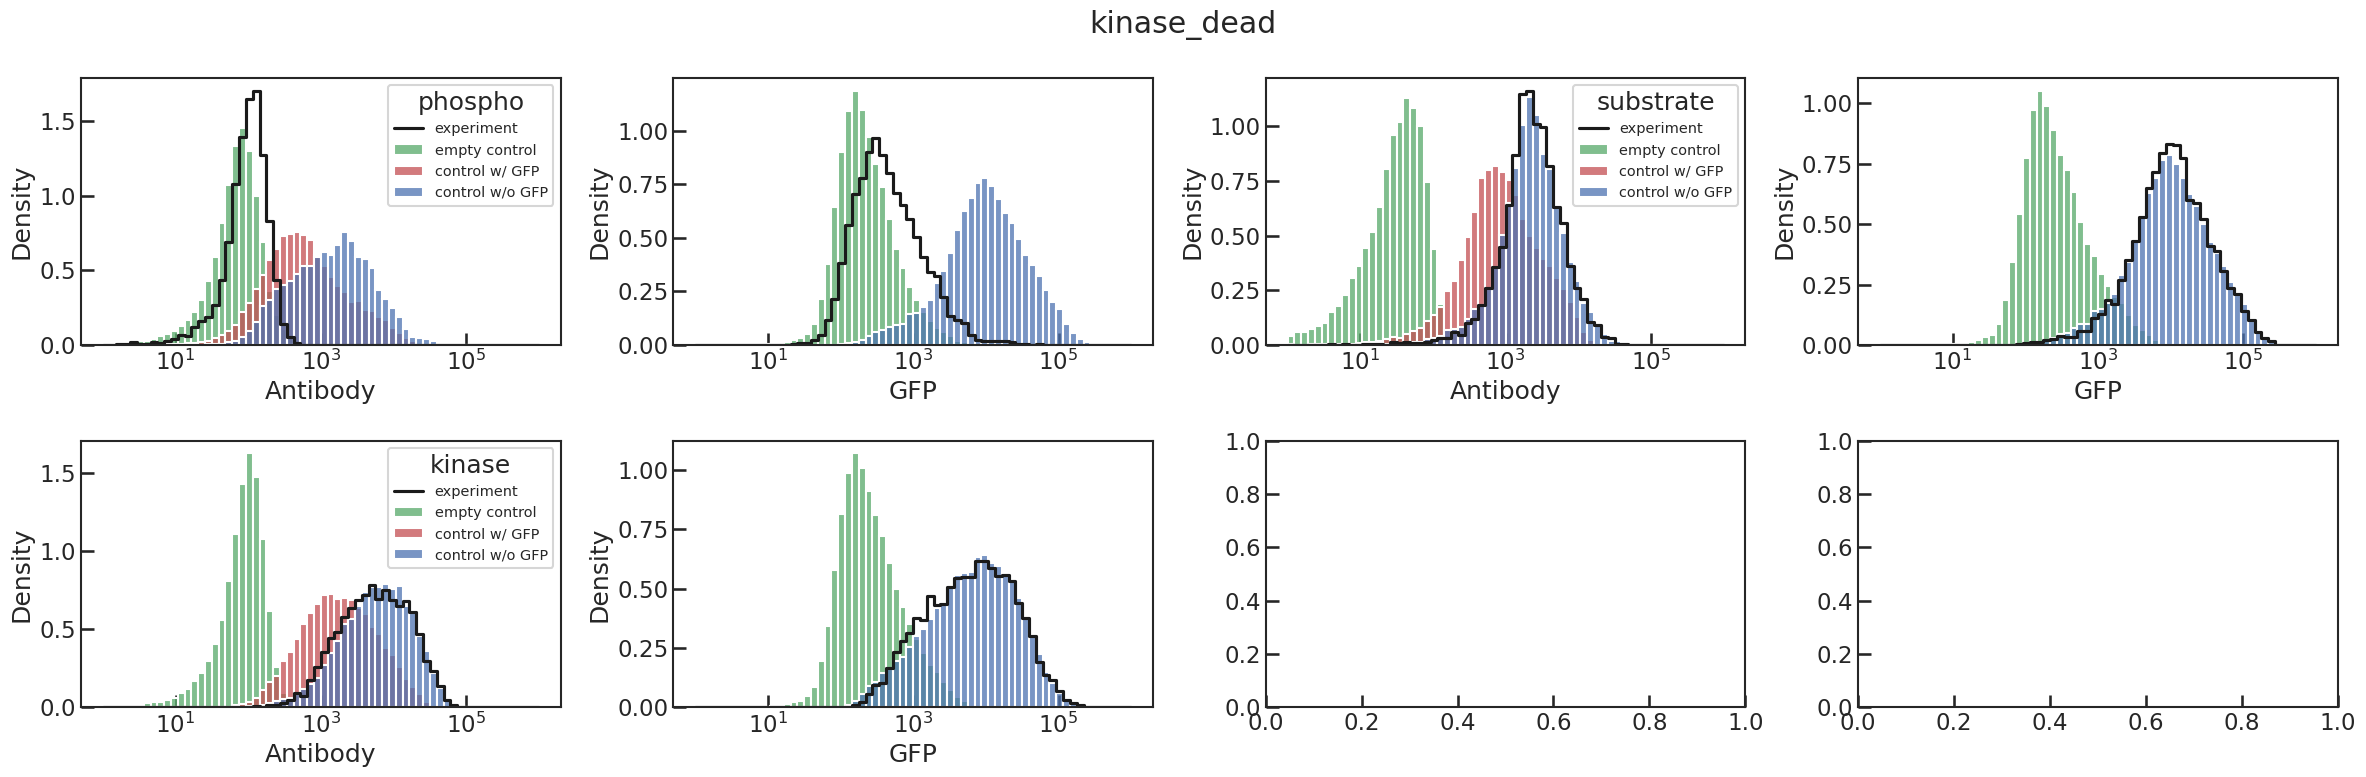

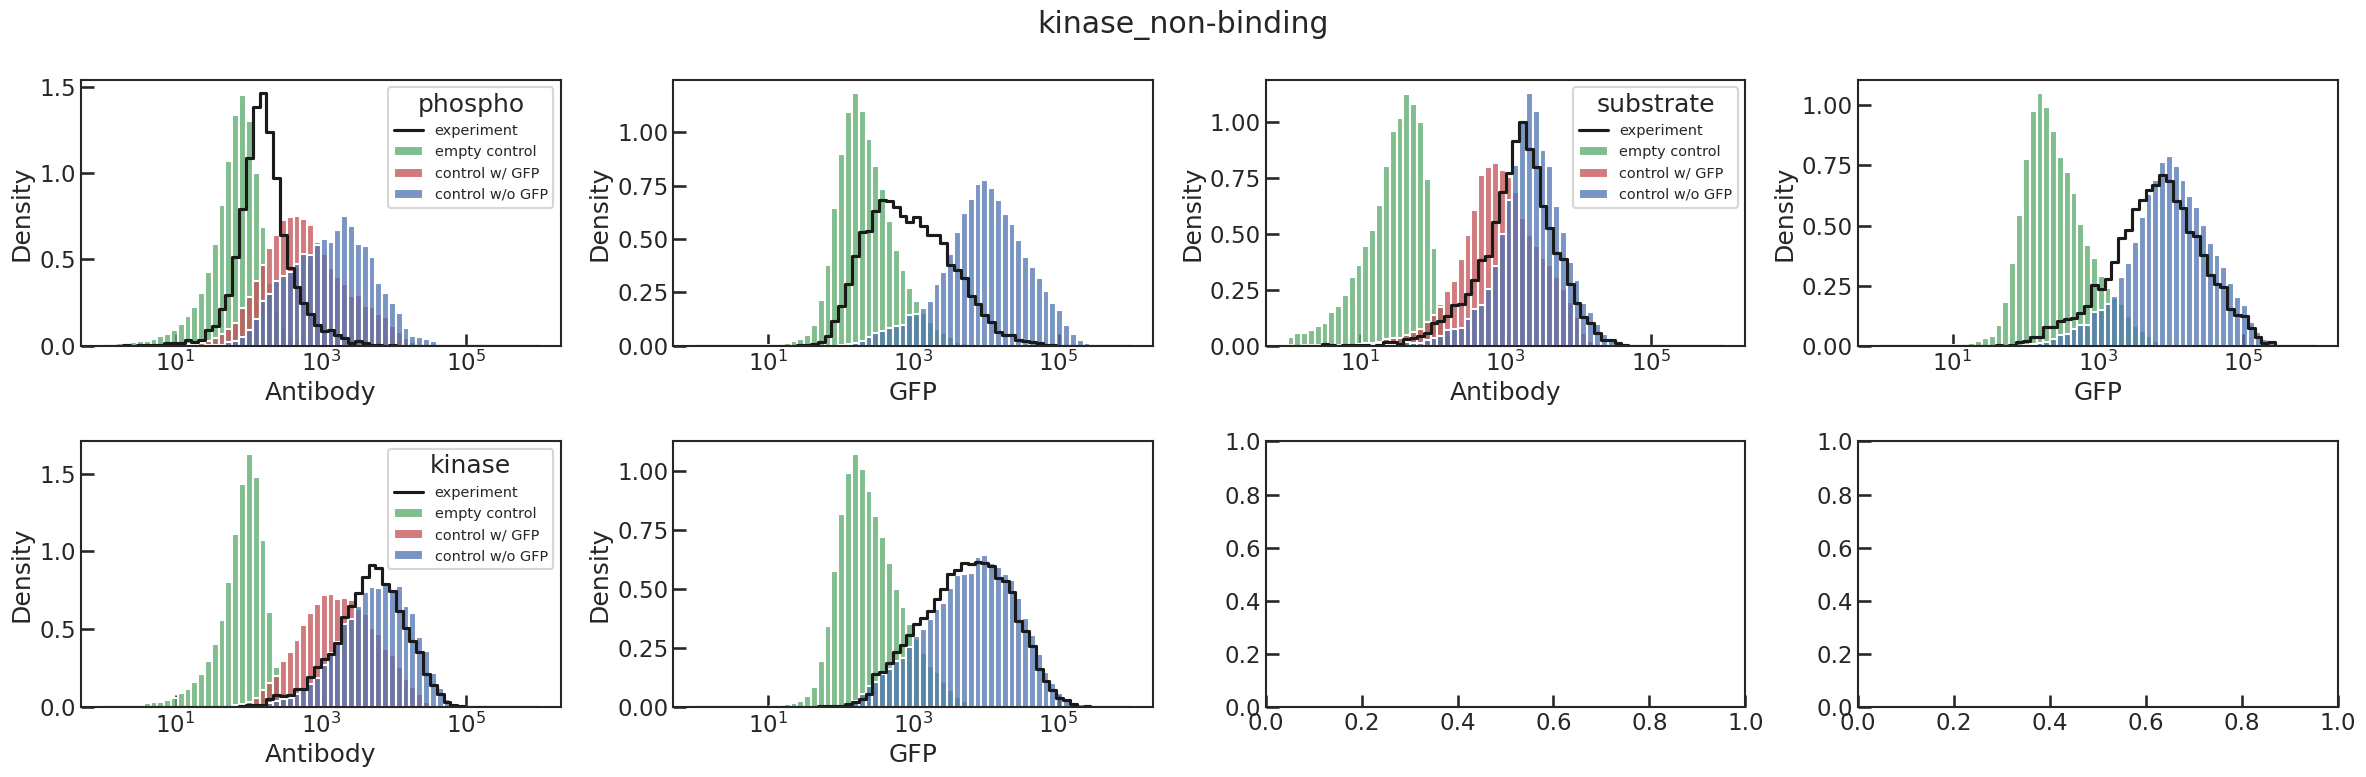

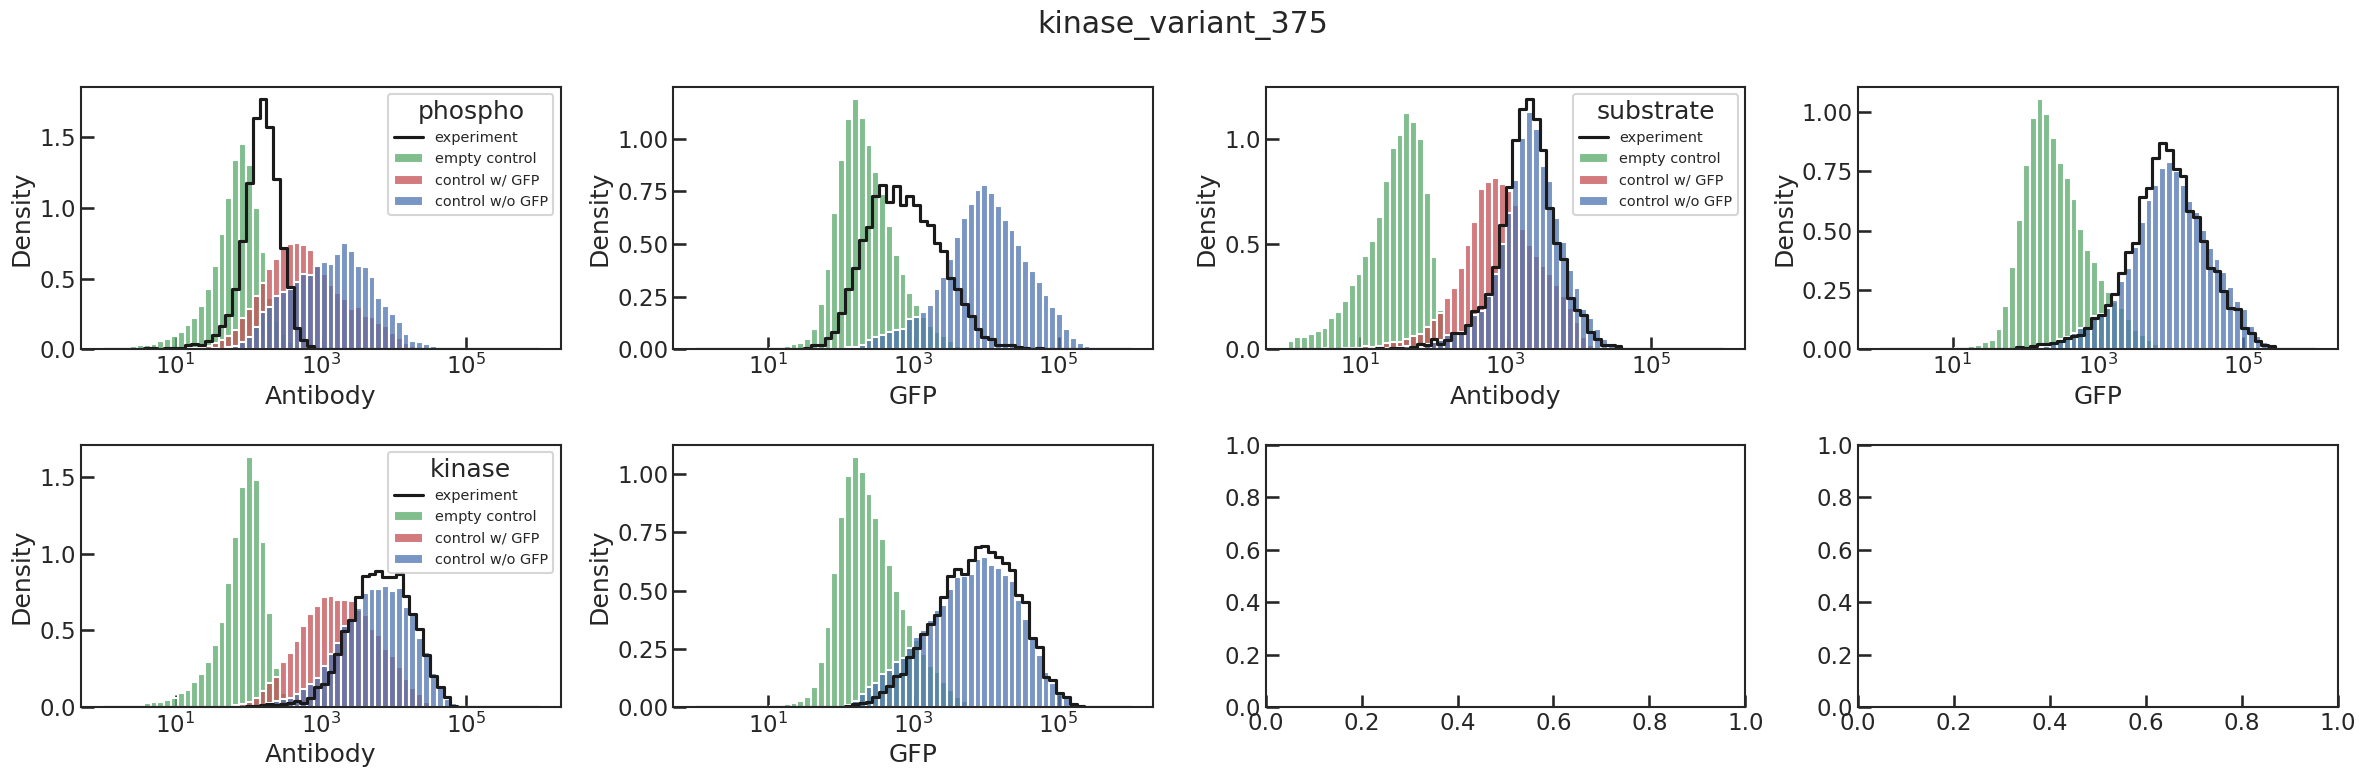

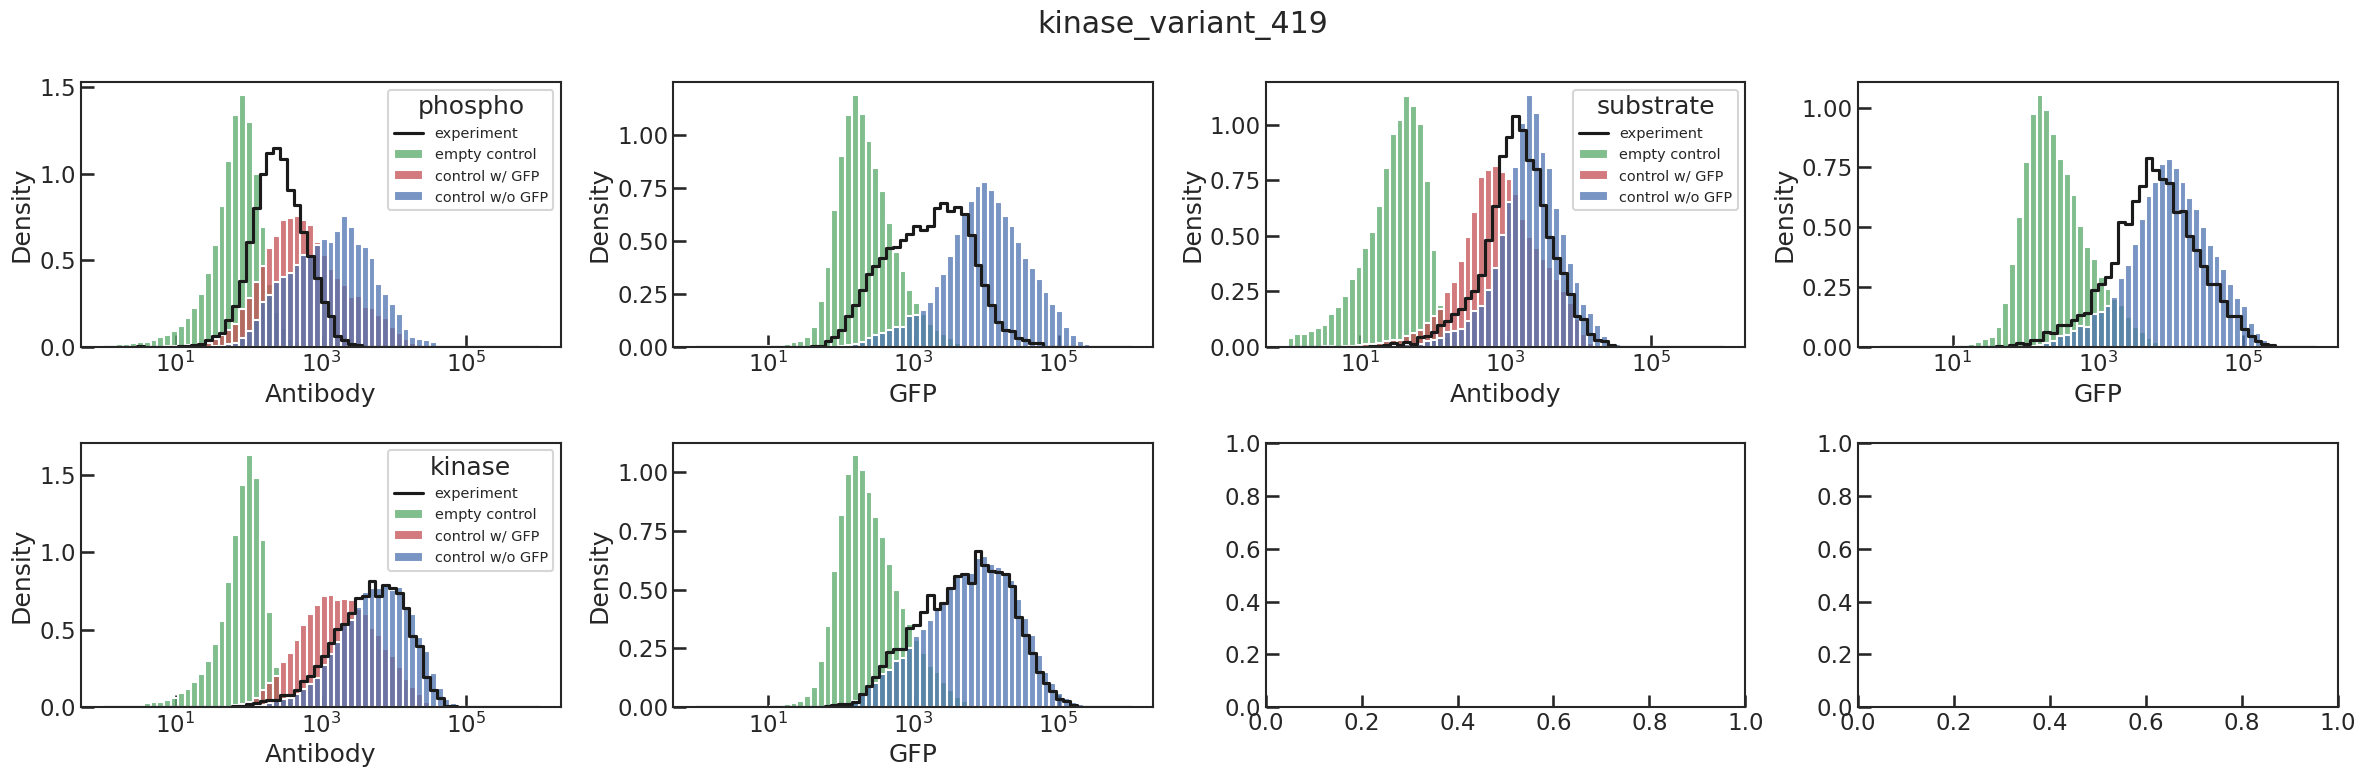

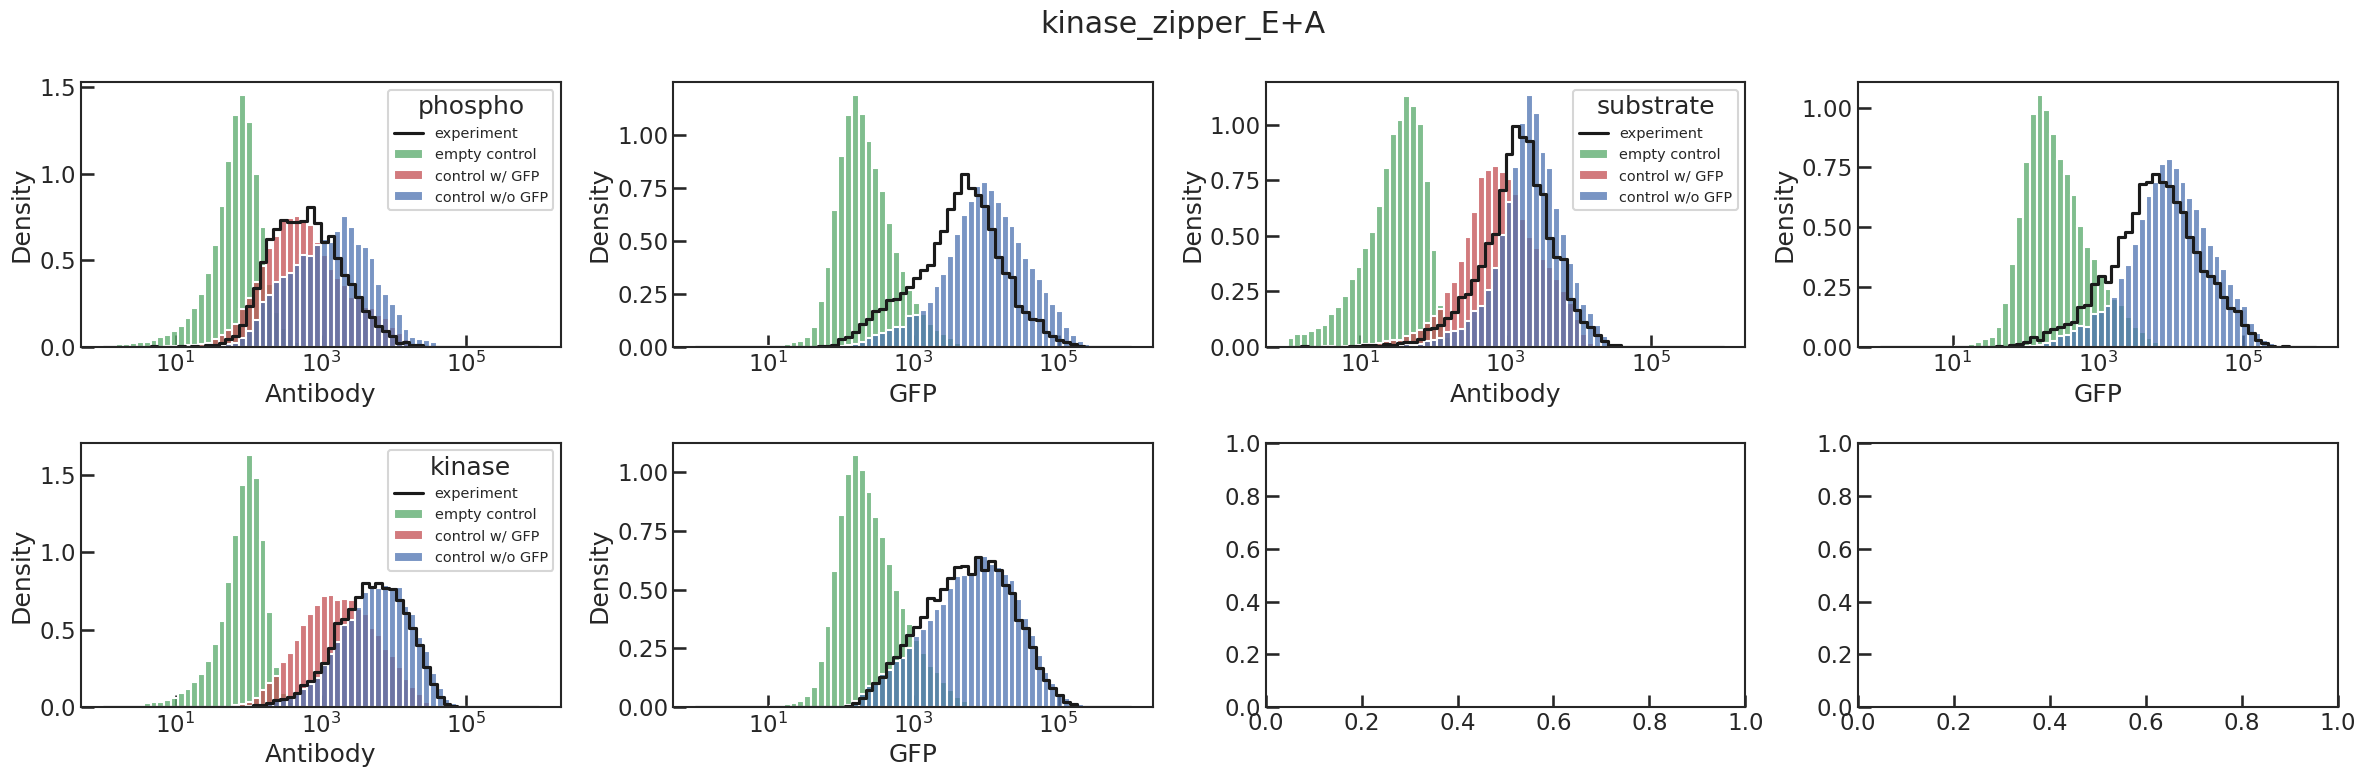

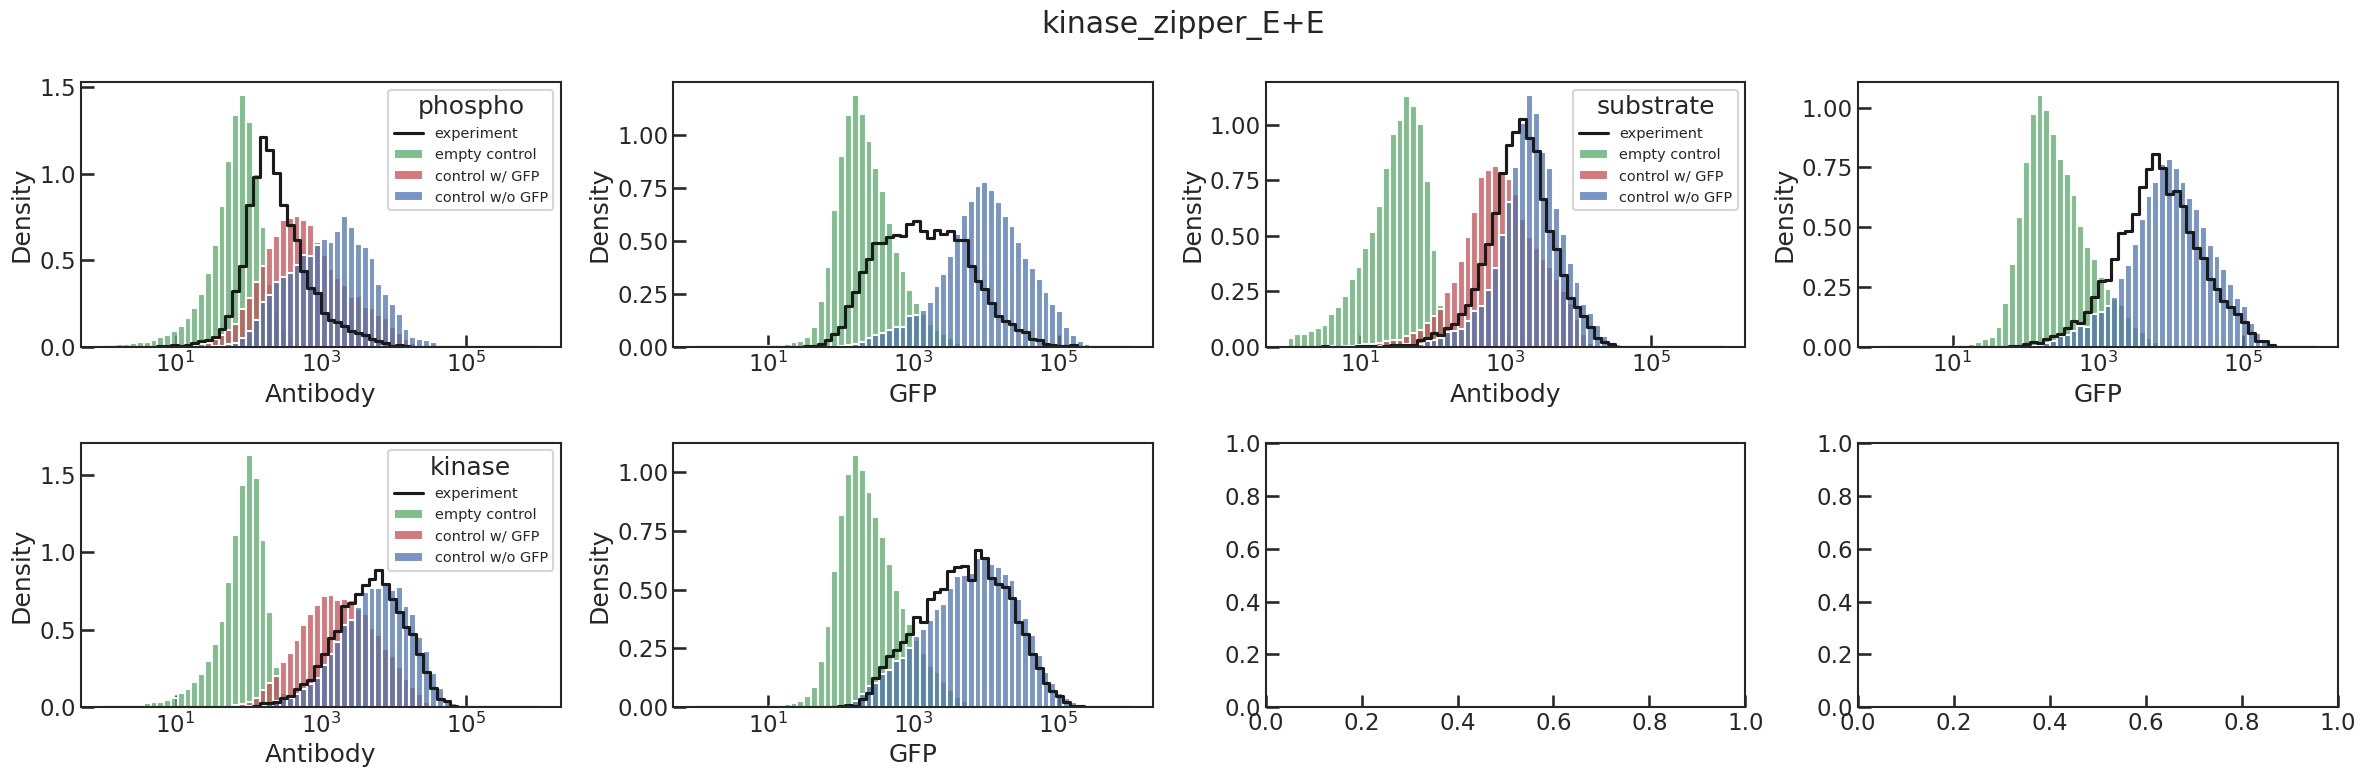

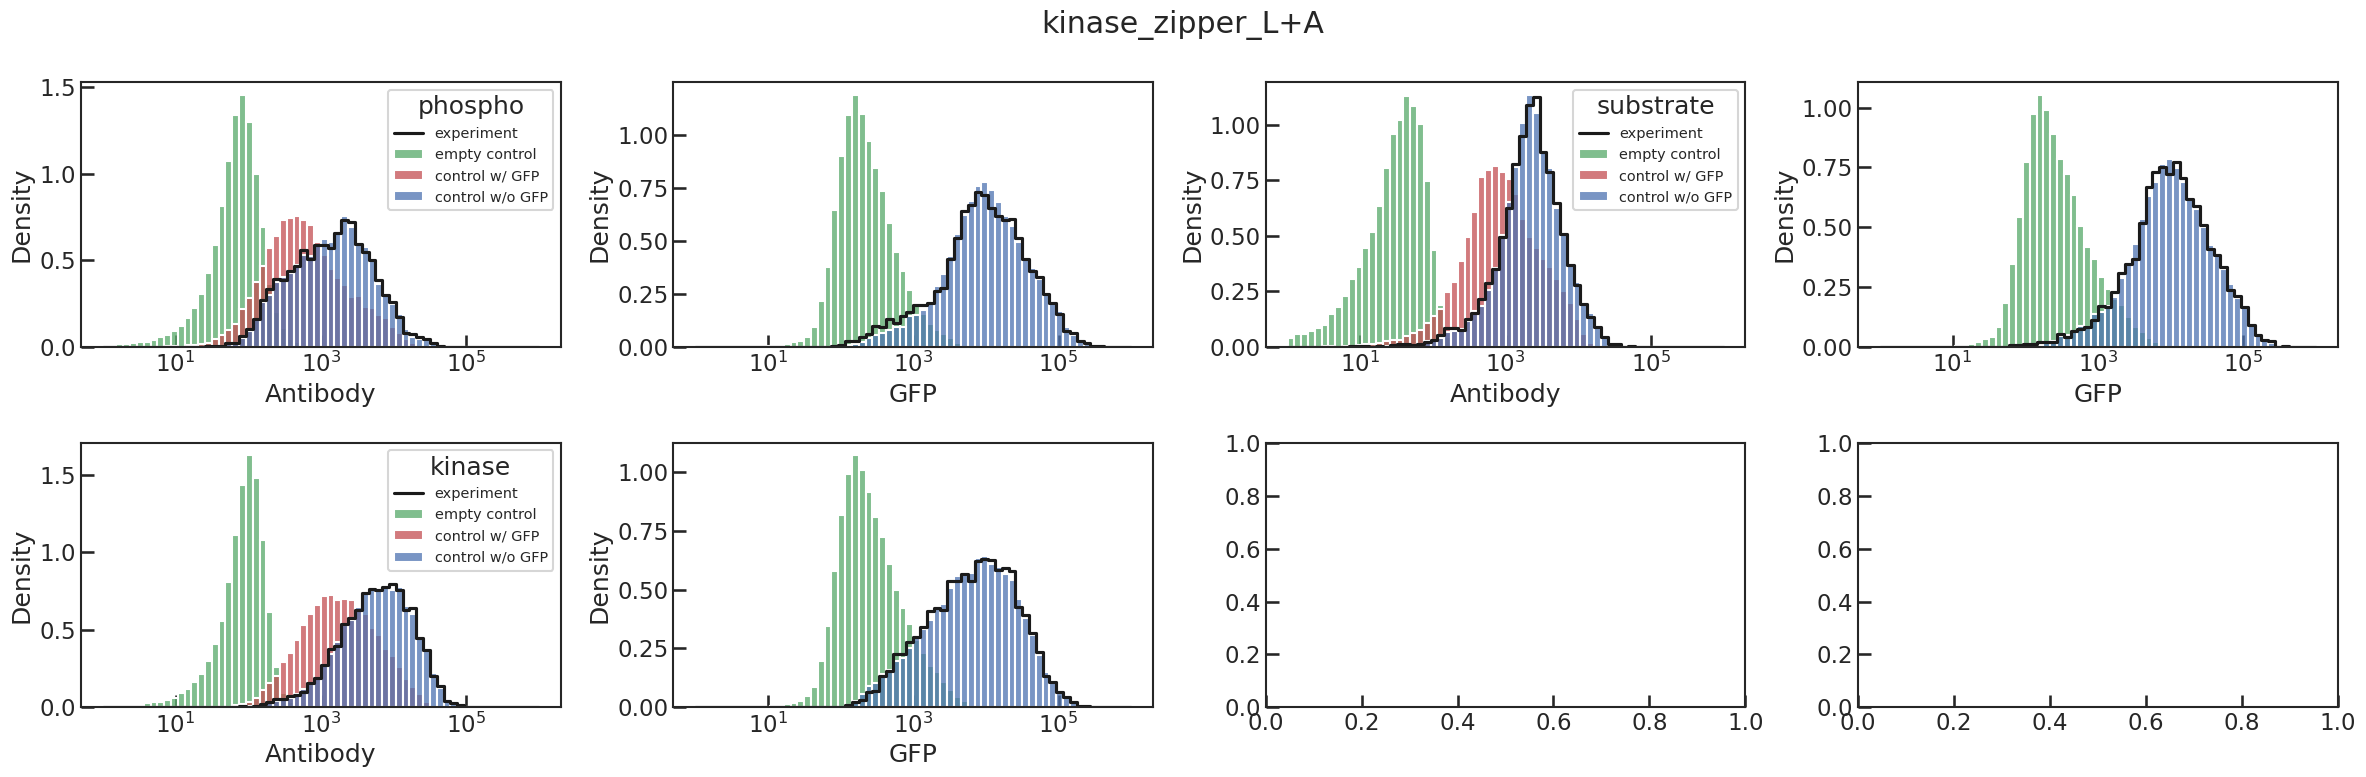

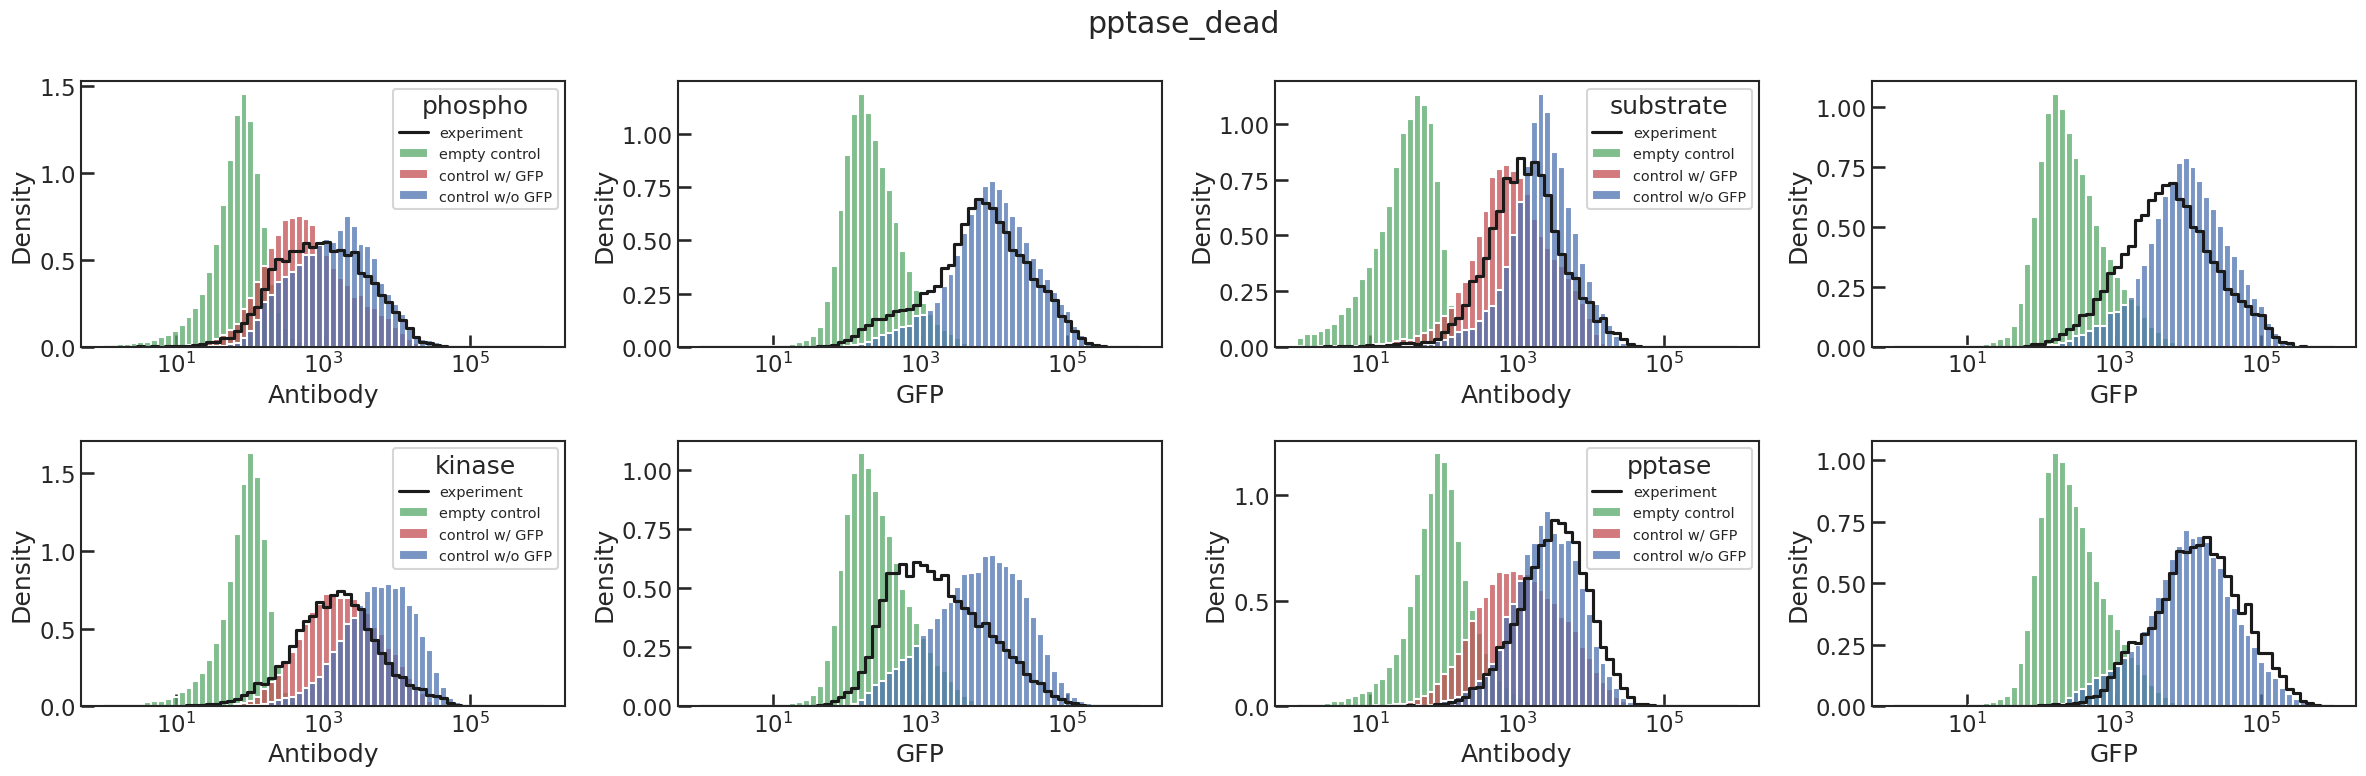

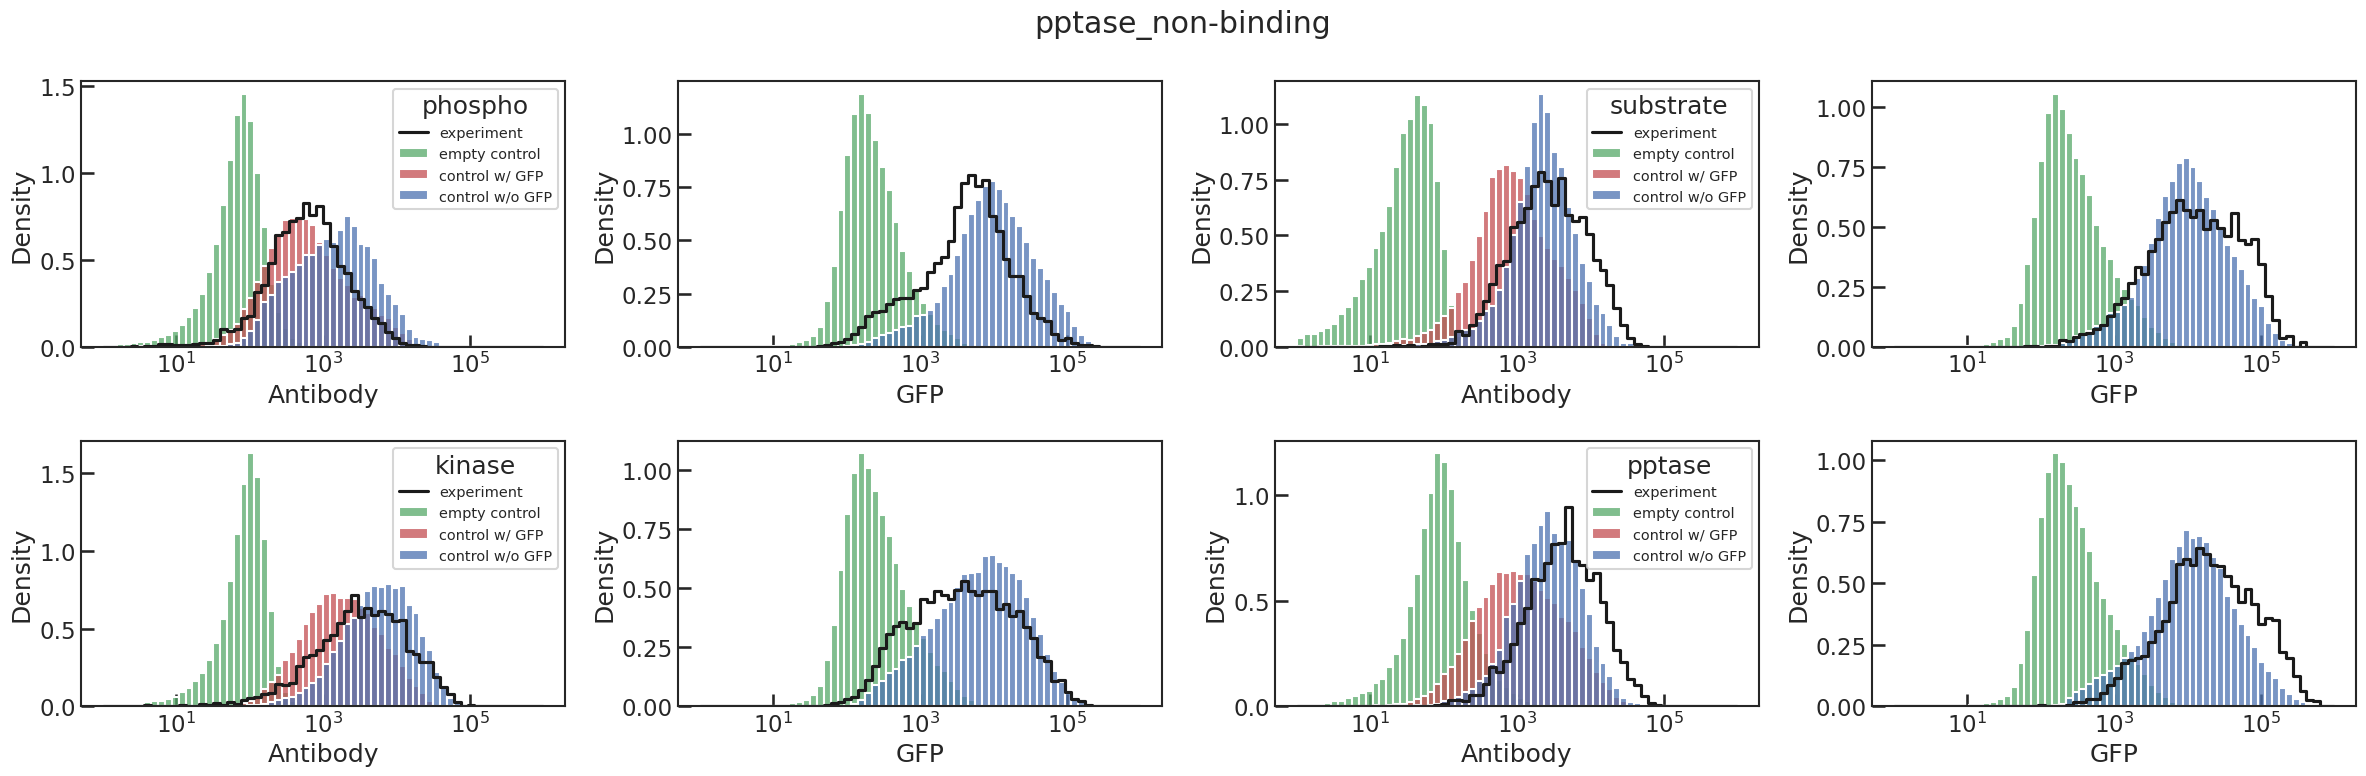

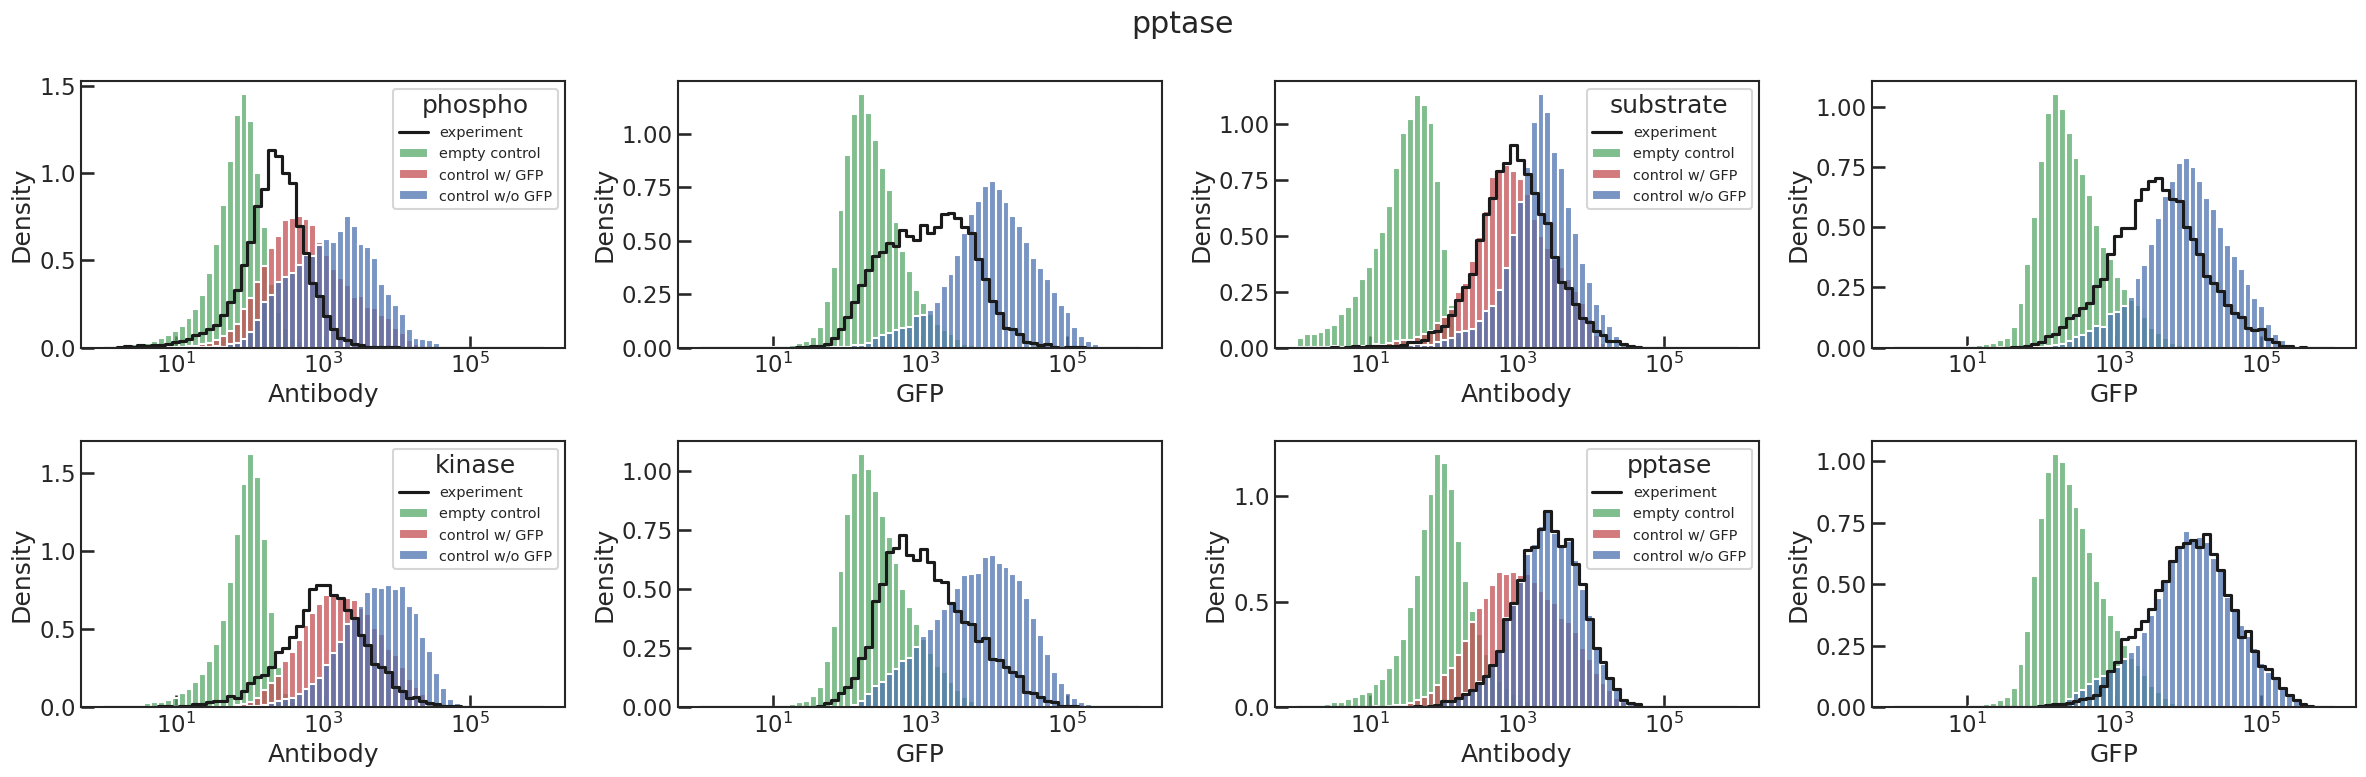

In [8]:

for exp_name, row in df_dataset_key.iterrows():
    
    df_tmp = df_data.query("exp_name==@exp_name").dropna()
    
    binrange = (0, 6)
        
    
    
    fig, axes = plt.subplots(2, 4, figsize=(24, 8), squeeze=False)
    
    fig.suptitle(exp_name)
    
    for c in components:
        
        
        if row['model'] != 'pushpull' and c=='pptase':
            continue
    
        if c == 'phospho':
            ax1 = axes[0, 0]
            ax2 = axes[0, 1]
        elif c == 'substrate':
            ax1 = axes[0, 2]
            ax2 = axes[0, 3]
        elif c == "kinase":
            ax1 = axes[1, 0]
            ax2 = axes[1, 1]
        else:
            ax1 = axes[1, 2]
            ax2 = axes[1, 3]
                        

        ax = ax1
        


#         ax.text(0.05, 0.95, c, va='top', ha='left', transform=ax.transAxes, fontsize='large')

        sns.histplot(noise_models[c]['empty_anti'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='empty control', color='g', stat='density')
        sns.histplot(noise_models[c]['anti'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='control w/ GFP', color='r', stat='density')
        sns.histplot(noise_models[c]['anti_noGFP'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='control w/o GFP', color='b', stat='density')
        sns.histplot(df_tmp[c+"_anti_exp"], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='experiment', element='step', fill=False, color='k', stat='density')


        ax.set_xscale('log')
        ax.set_xlabel("Antibody")

        ax.legend(loc='upper right', fontsize='xx-small', title=c)



        ax = ax2

        sns.histplot(noise_models[c]['empty_GFP'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='empty control', color='g', stat='density')
        sns.histplot(noise_models[c]['GFP'].df['vals'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='control', color='b', stat='density')
        sns.histplot(df_tmp[c+"_GFP_infer"], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                     label='inferred GFP', element='step', fill=False, color='k', stat='density')


        ax.set_xscale('log')
        ax.set_xlabel("GFP")
        
            


    plt.tight_layout()
    plt.show()
        
                

    

# Fit model

In [9]:
start = time.time()

res, param_dict = fit.fit_push(df_dataset_key, df_data, noise_models['phospho']['empty_GFP'].median)

end = time.time()

print(end-start)

{'bg_phospho_rate': 0, 'kinase_dead': 1, 'L+A': 2, 'kinase_wt': 3, 'kinase_non-binding': 4, '375': 5, '419': 6, 'E+A': 7, 'E+E': 8, 'pptase_dead': 9, 'pptase_wt': 10, 'pptase_non-binding': 11}
{'substrate_only': [0], 'non-pplatable': [], 'kinase_dead': [0, 1, 2], 'kinase_non-binding': [0, 3, 4], 'kinase_variant_375': [0, 5, 2], 'kinase_variant_419': [0, 6, 2], 'kinase_zipper_E+A': [0, 3, 7], 'kinase_zipper_E+E': [0, 3, 8], 'kinase_zipper_L+A': [0, 3, 2], 'pptase_dead': [0, 3, 2, 9, 2], 'pptase_non-binding': [0, 3, 2, 10, 11], 'pptase': [0, 3, 2, 10, 2]}
[-2.0, -1.0, 3.0, -1.0, 3.0, -1.0, -1.0, 3.0, 3.0, -1.0, -1.0, 3.0]
[(-8, 1), (-8, 1), (-8, 8), (-8, 1), (-8, 8), (-8, 1), (-8, 1), (-8, 8), (-8, 8), (-8, 1), (-8, 1), (-8, 8)]
#############################################################
Total Loss: 8.322013045645734 Regularization: 0.0
bg_phospho_rate -2.0 -2.0
kinase_dead -1.0 -1.0
L+A 3.0 3.0
kinase_wt -1.0 -1.0
kinase_non-binding 3.0 3.0
375 -1.0 -1.0
419 -1.0 -1.0
E+A 3.0 3.0
E+E 

file_name           model kinase_variant  \
exp_name                                                                
substrate_only                     127  substrate_only            NaN   
non-pplatable                      174   non-pplatable            174   
kinase_dead                        421            push    kinase_dead   
kinase_non-binding                RR+A            push      kinase_wt   
kinase_variant_375                 375            push            375   
kinase_variant_419                 419            push            419   
kinase_zipper_E+A                  E+A            push      kinase_wt   
kinase_zipper_E+E                  E+E            push      kinase_wt   
kinase_zipper_L+A                  L+A            push      kinase_wt   
pptase_dead                pptase dead        pushpull      kinase_wt   
pptase_non-binding  non-binding pptase        pushpull      kinase_wt   
pptase                     with pptase        pushpull      kinase_wt   

                         kinase_zipper pptase_variant       pptase_zipper  \
exp_name                                                                    
substrate_only                     NaN            NaN                 NaN   
non-pplatable                      L+A            NaN                 NaN   
kinase_dead                        L+A            NaN                 NaN   
kinase_non-binding  kinase_non-binding            NaN                 NaN   
kinase_variant_375                 L+A            NaN                 NaN   
kinase_variant_419                 L+A            NaN                 NaN   
kinase_zipper_E+A                  E+A            NaN                 NaN   
kinase_zipper_E+E                  E+E            NaN                 NaN   
kinase_zipper_L+A                  L+A            NaN                 NaN   
pptase_dead                        L+A    pptase_dead                 L+A   
pptase_non-binding                 L+A      pptase_wt  pptase_non-binding   
pptase                             L+A      pptase_wt                 L+A   

                   substrate_col phospho_col kinase_col pptase_col  \
exp_name                                                             
substrate_only                ST         SpT         WT        NaN   
non-pplatable                 ST         SpT         WT        NaN   
kinase_dead                   ST         SpT         WT        NaN   
kinase_non-binding            ST         SpT         WT        NaN   
kinase_variant_375            ST         SpT         WT        NaN   
kinase_variant_419            ST         SpT         WT        NaN   
kinase_zipper_E+A             ST         SpT         WT        NaN   
kinase_zipper_E+E             ST         SpT         WT        NaN   
kinase_zipper_L+A             ST         SpT         WT        NaN   
pptase_dead                   ST         SpT         WT     pptase   
pptase_non-binding            ST         SpT         WT     pptase   
pptase                        ST         SpT         WT     pptase   

                    bg_phospho_rate  kinase_phospho_rate  \
exp_name                                                   
substrate_only             0.021634                  NaN   
non-pplatable                   NaN                  NaN   
kinase_dead                0.021634             0.000005   
kinase_non-binding         0.021634            10.000000   
kinase_variant_375         0.021634             0.043799   
kinase_variant_419         0.021634             0.431063   
kinase_zipper_E+A          0.021634            10.000000   
kinase_zipper_E+E          0.021634            10.000000   
kinase_zipper_L+A          0.021634            10.000000   
pptase_dead                0.021634            10.000000   
pptase_non-binding         0.021634            10.000000   
pptase                     0.021634            10.000000   

                    kinase_binding_affinity  pptase_dephospho_rate  \
exp_name                           

2580.458564519882


# Save model parameters


In [10]:
df_dataset_key.to_csv("../data/"+label+"/model_params.csv", sep=',', index=True)

# Load model parameters if fitting was performed previously

In [11]:
df_dataset_key = pd.read_csv("../data/"+label+"/model_params.csv", sep=',', engine='python', index_col='exp_name')

display(df_dataset_key)

file_name           model kinase_variant  \
exp_name                                                                
substrate_only                     127  substrate_only            NaN   
non-pplatable                      174   non-pplatable            174   
kinase_dead                        421            push    kinase_dead   
kinase_non-binding                RR+A            push      kinase_wt   
kinase_variant_375                 375            push            375   
kinase_variant_419                 419            push            419   
kinase_zipper_E+A                  E+A            push      kinase_wt   
kinase_zipper_E+E                  E+E            push      kinase_wt   
kinase_zipper_L+A                  L+A            push      kinase_wt   
pptase_dead                pptase dead        pushpull      kinase_wt   
pptase_non-binding  non-binding pptase        pushpull      kinase_wt   
pptase                     with pptase        pushpull      kinase_wt   

                         kinase_zipper pptase_variant       pptase_zipper  \
exp_name                                                                    
substrate_only                     NaN            NaN                 NaN   
non-pplatable                      L+A            NaN                 NaN   
kinase_dead                        L+A            NaN                 NaN   
kinase_non-binding  kinase_non-binding            NaN                 NaN   
kinase_variant_375                 L+A            NaN                 NaN   
kinase_variant_419                 L+A            NaN                 NaN   
kinase_zipper_E+A                  E+A            NaN                 NaN   
kinase_zipper_E+E                  E+E            NaN                 NaN   
kinase_zipper_L+A                  L+A            NaN                 NaN   
pptase_dead                        L+A    pptase_dead                 L+A   
pptase_non-binding                 L+A      pptase_wt  pptase_non-binding   
pptase                             L+A      pptase_wt                 L+A   

                   substrate_col phospho_col kinase_col pptase_col  \
exp_name                                                             
substrate_only                ST         SpT         WT        NaN   
non-pplatable                 ST         SpT         WT        NaN   
kinase_dead                   ST         SpT         WT        NaN   
kinase_non-binding            ST         SpT         WT        NaN   
kinase_variant_375            ST         SpT         WT        NaN   
kinase_variant_419            ST         SpT         WT        NaN   
kinase_zipper_E+A             ST         SpT         WT        NaN   
kinase_zipper_E+E             ST         SpT         WT        NaN   
kinase_zipper_L+A             ST         SpT         WT        NaN   
pptase_dead                   ST         SpT         WT     pptase   
pptase_non-binding            ST         SpT         WT     pptase   
pptase                        ST         SpT         WT     pptase   

                    bg_phospho_rate  kinase_phospho_rate  \
exp_name                                                   
substrate_only             0.021634                  NaN   
non-pplatable                   NaN                  NaN   
kinase_dead                0.021634             0.000005   
kinase_non-binding         0.021634            10.000000   
kinase_variant_375         0.021634             0.043799   
kinase_variant_419         0.021634             0.431063   
kinase_zipper_E+A          0.021634            10.000000   
kinase_zipper_E+E          0.021634            10.000000   
kinase_zipper_L+A          0.021634            10.000000   
pptase_dead                0.021634            10.000000   
pptase_non-binding         0.021634            10.000000   
pptase                     0.021634            10.000000   

                    kinase_binding_affinity  pptase_dephospho_rate  \
exp_name                           

# Compute model predictions

In [12]:
# predict concentration values
# shift to GFP units

df_data['phospho_conc_predict'] = 0.0
df_data['phospho_GFP_predict'] = 0.0

for exp_name, row in df_dataset_key.iterrows():
    

    df_tmp = df_data.query("exp_name==@exp_name").dropna()

    if row['model'] == 'substrate_only':
        
        params = [row['bg_phospho_rate']]

        df_data.loc[df_tmp.index, 'phospho_conc_predict'] = thermo.predict_substrate_only(df_tmp['substrate_conc_infer'].values, *params)

    elif row['model'] == 'non-pplatable':

        df_data.loc[df_tmp.index, 'phospho_conc_predict'] = thermo.predict_nonpplatable(df_tmp['substrate_conc_infer'].values)

    elif row['model'] == 'push':
        
        params = [row['bg_phospho_rate'], row['kinase_phospho_rate'], row['kinase_binding_affinity']]

        df_data.loc[df_tmp.index, 'phospho_conc_predict'] = thermo.predict_push(df_tmp['kinase_conc_infer'].values, df_tmp['substrate_conc_infer'].values, *params)

    elif row['model'] == 'pushpull':
        
        params = [row['bg_phospho_rate'], row['kinase_phospho_rate'], row['kinase_binding_affinity'], row['pptase_dephospho_rate'], row['pptase_binding_affinity']]

        df_data.loc[df_tmp.index, 'phospho_conc_predict'] = thermo.predict_pushpull(df_tmp['kinase_conc_infer'].values, df_tmp['pptase_conc_infer'].values, df_tmp['substrate_conc_infer'].values, *params)


    df_data.loc[df_tmp.index, 'phospho_GFP_predict'] = df_data.loc[df_tmp.index, 'phospho_conc_predict'] + noise_models['phospho']['empty_GFP'].median
    

display(df_data)

print(len(df_data))
print(len(df_data.dropna()))

substrate_anti_exp  phospho_anti_exp  \
exp_name       cell_index                                         
substrate_only 0                  2212.525146        133.354218   
               1                  4954.513184        112.124626   
               2                  3487.114746        119.673706   
               3                   253.888428        100.082169   
               4                   584.118408         39.466415   
...                                       ...               ...   
pptase         15453               605.925781        116.375717   
               15454              3005.479980          3.798526   
               15455               140.026718        260.147644   
               15456               174.096863        169.258682   
               15457               363.897980        246.208633   

                           kinase_anti_exp  pptase_anti_exp  \
exp_name       cell_index                                     
substrate_only 0                 79.178284     1.000000e-08   
               1                 86.252625     1.000000e-08   
               2                 10.157516     1.000000e-08   
               3                 96.854454     1.000000e-08   
               4                118.221375     1.000000e-08   
...                                    ...              ...   
pptase         15453            585.051575     1.200013e+03   
               15454           7184.776367     4.150368e+03   
               15455            658.204529     5.767077e+02   
               15456            372.268127     7.306846e+02   
               15457            529.578430     9.265865e+02   

                           phospho_prob_empty  substrate_prob_empty  \
exp_name       cell_index                                             
substrate_only 0                     0.835467              0.003507   
               1                     0.924583              0.016788   
               2                     0.919016              0.009055   
               3                     0.946850              0.005789   
               4                     0.983930              0.005091   
...                                       ...                   ...   
pptase         15453                 0.928989              0.005091   
               15454                 1.000000              0.006101   
               15455                 0.347379              0.702666   
               15456                 0.669715              0.004919   
               15457                 0.291574              0.004794   

                           kinase_prob_empty  pptase_prob_empty  \
exp_name       cell_index                                         
substrate_only 0                    0.994416           0.000000   
               1                    0.993424           0.000000   
               2                    1.000000           0.000000   
               3                    0.992733           0.000000   
               4                    0.992449           0.000000   
...                                      ...                ...   
pptase         15453                0.010408           0.039166   
               15454                0.000000           0.003252   
               15455                0.010408           0.292457   
               15456                0.453276           0.194159   
               15457                0.010423           0.112482   

                           phospho_GFP_infer  phospho_conc_infer  \
exp_name       cell_index                                          
substrate_only 0                  552.593118          349.705895   
               1                  370.370807          167.483585   
               2                  131.236836            0.000000   
               3                 1588.078290         1385.191068   
               4                  136.507721            0.000000   
...                                      ...                 ..

139743
139715


# Convert predicted GFP values to antibody values in the absence of GFP

In [13]:
df_data['phospho_predict_prob_empty'] = 0.0
df_data['phospho_anti_predict'] = 0.0

for exp_name, row in df_dataset_key.iterrows():
    
    df_tmp = df_data.query("exp_name==@exp_name").dropna()

    p_empty = noise_models['phospho']['empty_GFP'].get_density(df_data.loc[df_tmp.index, 'phospho_GFP_predict'], log_scale=False)
    p_nempty =noise_models['phospho']['GFP'].get_density(df_data.loc[df_tmp.index, 'phospho_GFP_predict'], log_scale=False)
    idx = (p_empty > 0.0) | (p_nempty > 0.0)    
    df_data.loc[df_tmp.index[idx], 'phospho_predict_prob_empty'] = p_empty[idx] / (p_empty[idx] + p_nempty[idx])
    df_data.loc[df_tmp.index[~idx], 'phospho_predict_prob_empty'] = np.nan
    
    
    df_tmp = df_data.query("exp_name==@exp_name").dropna()
    
    q_empty = df_data.loc[df_tmp.index, 'phospho_predict_prob_empty'].values
    
    anti_wGFP = noise_models['phospho']['GFP2anti'].transform(df_tmp['phospho_GFP_predict'])
    
    idx = q_empty == 1.0
    df_data.loc[df_tmp.index[idx], 'phospho_anti_predict'] = noise_models['phospho']['empty_GFP2anti'].transform(df_data.loc[df_tmp.index[idx], 'phospho_GFP_predict'])

    idx = q_empty == 0.0
    if antibody_shift:
        df_data.loc[df_tmp.index[idx], 'phospho_anti_predict'] = noise_models['phospho']['antiwGFP2anti'].transform(anti_wGFP[idx])
    else:
        df_data.loc[df_tmp.index[idx], 'phospho_anti_predict'] = anti_wGFP[idx]
        
    idx = (q_empty > 0.0) & (q_empty < 1.0)
    if antibody_shift:
        df_data.loc[df_tmp.index[idx], 'phospho_anti_predict'] = q_empty[idx]*noise_models['phospho']['empty_GFP2anti'].transform(df_data.loc[df_tmp.index[idx], 'phospho_GFP_predict']) \
                                                                + (1-q_empty[idx])*noise_models['phospho']['antiwGFP2anti'].transform(anti_wGFP[idx])
    else:
        df_data.loc[df_tmp.index[idx], 'phospho_anti_predict'] = q_empty[idx]*noise_models['phospho']['empty_GFP2anti'].transform(df_data.loc[df_tmp.index[idx], 'phospho_GFP_predict']) \
                                                                + (1-q_empty[idx])*anti_wGFP[idx]
    
display(df_data)

substrate_anti_exp  phospho_anti_exp  \
exp_name       cell_index                                         
substrate_only 0                  2212.525146        133.354218   
               1                  4954.513184        112.124626   
               2                  3487.114746        119.673706   
               3                   253.888428        100.082169   
               4                   584.118408         39.466415   
...                                       ...               ...   
pptase         15453               605.925781        116.375717   
               15454              3005.479980          3.798526   
               15455               140.026718        260.147644   
               15456               174.096863        169.258682   
               15457               363.897980        246.208633   

                           kinase_anti_exp  pptase_anti_exp  \
exp_name       cell_index                                     
substrate_only 0                 79.178284     1.000000e-08   
               1                 86.252625     1.000000e-08   
               2                 10.157516     1.000000e-08   
               3                 96.854454     1.000000e-08   
               4                118.221375     1.000000e-08   
...                                    ...              ...   
pptase         15453            585.051575     1.200013e+03   
               15454           7184.776367     4.150368e+03   
               15455            658.204529     5.767077e+02   
               15456            372.268127     7.306846e+02   
               15457            529.578430     9.265865e+02   

                           phospho_prob_empty  substrate_prob_empty  \
exp_name       cell_index                                             
substrate_only 0                     0.835467              0.003507   
               1                     0.924583              0.016788   
               2                     0.919016              0.009055   
               3                     0.946850              0.005789   
               4                     0.983930              0.005091   
...                                       ...                   ...   
pptase         15453                 0.928989              0.005091   
               15454                 1.000000              0.006101   
               15455                 0.347379              0.702666   
               15456                 0.669715              0.004919   
               15457                 0.291574              0.004794   

                           kinase_prob_empty  pptase_prob_empty  \
exp_name       cell_index                                         
substrate_only 0                    0.994416           0.000000   
               1                    0.993424           0.000000   
               2                    1.000000           0.000000   
               3                    0.992733           0.000000   
               4                    0.992449           0.000000   
...                                      ...                ...   
pptase         15453                0.010408           0.039166   
               15454                0.000000           0.003252   
               15455                0.010408           0.292457   
               15456                0.453276           0.194159   
               15457                0.010423           0.112482   

                           phospho_GFP_infer  phospho_conc_infer  \
exp_name       cell_index                                          
substrate_only 0                  552.593118          349.705895   
               1                  370.370807          167.483585   
               2                  131.236836            0.000000   
               3                 1588.078290         1385.191068   
               4                  136.507721            0.000000   
...                                      ...                 ..

# Save predictions

In [14]:
df_data.to_csv("../data/"+label+"/model_predictions.csv", sep=',')